# 0. Objective
- The **TASK 1** is to predict the store-wide and departmental or categorical sales for each store for weeks in the future.
- The **TASK 2** is to evaluate the effect of the markdowns and/or CPI, temperatures, etc. on sales preceding the major holidays.
- 
<div style="text-align: center;">
	<img src="holiday_dates.jpg" alt="Holiday Dates">
</div>

# 1. Module Management, Data and auxiliary data import

- The first four CSV files are from the Kaggle competition [Walmart Recruiting - Store Sales Forecasting](https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting/data). The last CSV file is from the Walmart website [Walmart Departments](https://www.kaggle.com/manjeetsingh/retaildataset). 

- The 5th CSV file is a dataset that contains the department names and their respective department numbers we used NLP tools to extract the department names, the department numbers, the In-Full Category, and the Merch Align from [this source](https://5407613.fs1.hubspotusercontent-na1.net/hubfs/5407613/SW%20-%20Ebooks%20%2B%20Resources/%5BOFFICIAL%5DWalmartDepartments%2cCategories%2candFinelines-Final%20(1).pdf). We can use this piece of information to understand the department names and their respective department numbers, then cluster departments sharing the same In-Full Category and Merch Align together to get better insights and predictions about the sales data.
<div style="text-align: center;">
	<img src="dept.png" alt="Holiday Dates">
</div>

  

In [85]:
## Library
# Data handling
import pandas as pd
import numpy as np
import pickle
pd.options.mode.copy_on_write = True

In [2]:
# Viz
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [3]:
# ML
from sklearn import model_selection
from sklearn import pipeline
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pmd

In [4]:
# Aesthetics
sns.set_style("ticks")
matplotlib.rcParams['figure.figsize'] = (12, 6)
matplotlib.rcParams['font.size'] = 12
pd.options.display.max_columns = None
pd.options.display.max_rows = 20

In [5]:
features = pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
walmart_dept = pd.read_csv('walmart-departments.csv')

## 1.1 Table descriptions: features
- Store - the store number, 1-45
- Date - 182 week from 2010-02-05 to 2013-07-26 on Fridays, but we only have sales data from 2010-02-05 to 2012-10-26. That means we only have sales data for 143 weeks to train our model and validate it.
- Temperature - average Fahrenheit temperature in the region
- Fuel_Price - cost of fuel in the region
- MarkDown1-5 - anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA. (This is a key field for the competition.) Most likely the missing values are due to no promotions running that week.
- CPI - the consumer price index. NA values are only for weeks on and after 2013-05-03, which are outside the scope of our model training. Just drop those weeks for now.
- Unemployment - the unemployment rate. NA values are only for weeks on and after 2013-05-03, which are outside the scope of our model training. Just drop those weeks for now.
- IsHoliday - whether the week is a special holiday week. 

In [6]:
features.info()
features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         8190 non-null   int64  
 1   Date          8190 non-null   object 
 2   Temperature   8190 non-null   float64
 3   Fuel_Price    8190 non-null   float64
 4   MarkDown1     4032 non-null   float64
 5   MarkDown2     2921 non-null   float64
 6   MarkDown3     3613 non-null   float64
 7   MarkDown4     3464 non-null   float64
 8   MarkDown5     4050 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     8190 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 712.0+ KB


,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


## 1.2 Table descriptions: stores
- Store - the store number, 1-45
- Type - the store type. The type of store is indicated by a letter A, B, or C.
- Size - the store size in square feet


In [7]:
stores.info()
stores.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


## 1.3 Table descriptions: train
- Store - the store number, 1-45
- Dept - the department number
- Date - 143 week from 2010-02-05 to 2012-10-26 on Fridays.
- Weekly_Sales - sales for the given department in the given store
- IsHoliday - whether the week is a special holiday week.

In [8]:
train.info()
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


## 1.4 Table descriptions: test
This file is __identical to train.csv__, except we have withheld the weekly sales from the week 2012-11-02 to 2013-07-26. So, basically, we have to predict the sales for each triplet of store, department, and date in this file.

## 1.5 Table descriptions: walmart_dept 
- Accounting Department - Same as the department number, 1-99. Only 81 of them are present in the original dataset, and 87 are present in the walmart_dept dataset. And department 48 does not have its corresponding department name in the walmart_dept dataset.
- From [this source](https://technomantic.com/walmart-department-numbers/), we find that Department 48 is the "Firearms" department, which cannot be found in the walmart_dept dataset. If needed, it can be substituted with the "Sporting Goods" department, which is the "General Merchandise" In Full Category and "Hardlines" Merch Align.
- Department Name - the department name corresponding to the department number. Some department codes share the SAME department name, but not necessarily the same In-Full Category and Merch Align. We find some of the department names are not unique, and some department names are not present in the original dataset. We will substitute the department names that are not present in the original dataset with the department numbers that have the same department names in the original dataset. After this department grouping, we will have 71 departments in the walmart_dept dataset.
	- 'Stationery' is named as 03 Stationery, covering 3 departments [3, 53, 73].
	- 'Piece Goods Fabrics and Crafts' is named as 19 Piece Goods Fabrics and Crafts, covering 3 departments [19, 44, 52].
	- 'Jewelry' is named as 32 Jewelry, covering 3 departments [32, 47, 54].
	- 'Sporting Goods' is named as 09 Sporting Goods, covering 3 departments [9, 45, 51].
	- 'Cosmetics Fragrances and Skin Care' is named as 46 Cosmetics Fragrances and Skin Care, covering 2 departments [46, 59].
	- 'Auto Service' is named as 37 Auto Service, covering 2 departments [37, 65].
	- 'Mens Wear' is named as 23 Mens Wear, covering 2 departments [23, 41].  
	- 'Optical' is named as 49 Optical, covering 2 departments [49, 58].  
	- 'Ladies Wear' is named as 34 Ladies Wear, covering 2 departments [34, 40].  
	- 'Deli' is named as 80 Deli, covering 2 departments [80, 97].  
	- 'Automotive' is named as 10 Automotive, covering 2 departments [10, 42].
	- 'Toys' is named as 7 Toys, covering 2 departments [7, 43].  
	- 'Media and Gaming' is named as 5 Media and Gaming, covering 2 departments [5, 55].
	

- In-Full Category - the category of the department, which is a high level of grouping of the departments. There are FIVE categories:
	- 'Consumables' with 8 departments,
	- 'Food' with 14 departments,
	- 'General Merchandise' with 52 departments,
	- 'Health and Wellness' with 5 departments,
	-  8 departments that are not originally labeled but assigned as 'Service' after reviewing the document details.  
- Merch Align - the merchandise alignment of the department, which is like a sub-category of the departments based on the properties of merchandises within the departments. There are 8 sub-categories:
	- 'Apparel' with 18 departments,
	- 'Consumables' with 7 departments, 
	- 'Entertainment, Toys, and Seasonal' with 10 departments,
	- 'Food' with 14 departments,
	- 'Hardlines' with 15 departments,
	- 'Health and Wellness' with 5 departments,
	- 'Home' with 10 departments,
	- 'Service' with 9 departments.

In [9]:
# find the department number that is present in the train dataset
np.sort(train['Dept'].unique())
# 81 unique values
# train['Dept'] misses 7 departments compared to walmart_dept['Accounting Department']
# missing 15 Health and Wellness
# missing 53 Stationery, which is substituted to 03 Stationery
# missing 57 Hearing Center
# missing 73 Stationery, which is substituted to 03 Stationery
# missing 86 Financial Services Walmart Services
# missing 88 PMDC Signage
# missing 89 Everyday Services Walmart Travel

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       54, 55, 56, 58, 59, 60, 65, 67, 71, 72, 74, 77, 78, 79, 80, 81, 82,
       83, 85, 87, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], dtype=int64)

In [10]:
# add Department 48 is the "Firearms" department, which is not present in the walmart_dept dataset. It can be substituted with the "Sporting Goods" department, which is the "General Merchandise" In Full Category and "Hardlines" Merch Align.
new_row = {'Accounting Department': 48, 'Department Name': 'Firearms', 'In Full Category': 'General Merchandise', 'Merch Align': 'Hardlines'}
walmart_dept = pd.concat([walmart_dept, pd.DataFrame([new_row])], ignore_index=True)

In [11]:
# find the department that can be substituted with the same department name in the dataset
walmart_dept['Department Name'].value_counts(dropna=False).head(14)

Department Name
Stationery                            3
Piece Goods Fabrics and Crafts        3
Jewelry                               3
Sporting Goods                        3
Cosmetics Fragrances and Skin Care    2
Auto Service                          2
Mens Wear                             2
Optical                               2
Ladies Wear                           2
Deli                                  2
Automotive                            2
Toys                                  2
Media and Gaming                      2
Concept Stores                        1
Name: count, dtype: int64

In [12]:
# Replace the department with name 'Stationery' with the department number 03, which is the main 'Stationery' department
dept_stationary = walmart_dept.loc[walmart_dept['Department Name'] == 'Stationery', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_stationary), 'Accounting Department'] = 3
# Replace the department with name 'Piece Goods Fabrics and Crafts' with the department number 19, which is the main 'Piece Goods Fabrics and Crafts' department
dept_piece_goods = walmart_dept.loc[walmart_dept['Department Name'] == 'Piece Goods Fabrics and Crafts', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_piece_goods), 'Accounting Department'] = 19
# Replace the department with name 'Jewelry' with the department number 32, which is the main 'Jewelry' department
dept_jewelry = walmart_dept.loc[walmart_dept['Department Name'] == 'Jewelry', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_jewelry), 'Accounting Department'] = 32
# Replace the department with name 'Sporting Goods' with the department number 09, which is the main 'Sporting Goods' department
dept_sporting_goods = walmart_dept.loc[walmart_dept['Department Name'] == 'Sporting Goods', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_sporting_goods), 'Accounting Department'] = 9
# Replace the department with name 'Cosmetics Fragrances and Skin Care' with the department number 46, which is the main 'Cosmetics Fragrances and Skin Care' department
dept_cosmetics = walmart_dept.loc[walmart_dept['Department Name'] == 'Cosmetics Fragrances and Skin Care', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_cosmetics), 'Accounting Department'] = 46
# Replace the department with name 'Auto Service' with the department number 37, which is the main 'Auto Service' department
dept_auto_service = walmart_dept.loc[walmart_dept['Department Name'] == 'Auto Service', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_auto_service), 'Accounting Department'] = 37
# Replace the department with name 'Mens Wear' with the department number 23, which is the main 'Mens Wear' department
dept_mens_wear = walmart_dept.loc[walmart_dept['Department Name'] == 'Mens Wear', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_mens_wear), 'Accounting Department'] = 23
# Replace the department with name 'Optical' with the department number 49, which is the main 'Optical' department
dept_optical = walmart_dept.loc[walmart_dept['Department Name'] == 'Optical', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_optical), 'Accounting Department'] = 49
# Replace the department with name 'Ladies Wear' with the department number 34, which is the main 'Ladies Wear' department
dept_ladies_wear = walmart_dept.loc[walmart_dept['Department Name'] == 'Ladies Wear', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_ladies_wear), 'Accounting Department'] = 34
# Replace the department with name 'Deli' with the department number 80, which is the main 'Deli' department
dept_deli = walmart_dept.loc[walmart_dept['Department Name'] == 'Deli', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_deli), 'Accounting Department'] = 80
# Replace the department with name 'Automotive' with the department number 10, which is the main 'Automotive' department
dept_automotive = walmart_dept.loc[walmart_dept['Department Name'] == 'Automotive', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_automotive), 'Accounting Department'] = 10
# Replace the department with name 'Toys' with the department number 7, which is the main 'Toys' department
dept_toys = walmart_dept.loc[walmart_dept['Department Name'] == 'Toys', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_toys), 'Accounting Department'] = 7
# Replace the department with name 'Media and Gaming' with the department number 5, which is the main 'Media and Gaming' department
dept_media_gaming = walmart_dept.loc[walmart_dept['Department Name'] == 'Media and Gaming', 'Accounting Department'].values
walmart_dept.loc[walmart_dept['Accounting Department'].isin(dept_media_gaming), 'Accounting Department'] = 5

In [13]:
# find the unique Accounting Department, In-Full Category and Merch Align in the dataset
n_dept = np.unique(walmart_dept['Accounting Department'],return_counts=True)
n_dept_name = np.unique(walmart_dept['Department Name'],return_counts=True)
n_category = np.unique(walmart_dept['In Full Category'],return_counts=True)
n_merch = np.unique(walmart_dept['Merch Align'],return_counts=True)
print(f"There are {len(n_dept[0])} unique departments in the dataset.")
print(f"There are {len(n_category[0])} unique categories in the dataset.")
print(f"There are {len(n_merch[0])} unique merch alignments in the dataset.")

There are 71 unique departments in the dataset.
There are 5 unique categories in the dataset.
There are 8 unique merch alignments in the dataset.


In [14]:
walmart_dept.groupby(['In Full Category','Merch Align'])[['Accounting Department','Department Name']].agg(lambda x: set(x.tolist())).reset_index()

,In Full Category,Merch Align,Accounting Department,Department Name
0,Consumables,Apparel,{79},{Infant Consumable Hardlines}
1,Consumables,Consumables,"{2, 4, 8, 40, 13, 46}","{Paper Goods Household Paper, Personal Care He..."
2,Food,Food,"{96, 1, 98, 80, 81, 82, 83, 90, 91, 92, 93, 94...","{Seafood, Deli, Impulse Merchandise, Frozen Fo..."
3,General Merchandise,Apparel,"{32, 33, 34, 35, 36, 23, 24, 25, 26, 27, 28, 2...","{Shoes, Infants Toddlers, Plus Size, Ladies We..."
4,General Merchandise,"Entertainment, Toys, and Seasonal","{67, 5, 6, 7, 72, 18, 21, 87}","{Books and Magazine, Wireless Wearables Camera..."
5,General Merchandise,Hardlines,"{3, 99, 9, 10, 11, 12, 77, 16, 48, 56}","{Large Appliances, Office and Store Supplies, ..."
6,General Merchandise,Home,"{71, 74, 14, 17, 19, 20, 22}","{Closet Storage and Organization, Piece Goods ..."
7,Health and Wellness,Health and Wellness,"{49, 57, 38, 15}","{Optical, Hearing Center, Prescription Pharmac..."
8,Service,Service,"{37, 39, 85, 86, 88, 89, 58, 60}","{PMDC Signage, Photo Services One Hour Photo, ..."


In [15]:
# drop the duplicates in the walmart_dept table
pd.options.display.max_rows = 25
walmart_dept = walmart_dept.drop_duplicates().reset_index(drop=True)
walmart_dept.sort_values(by='Accounting Department').reset_index(drop=True)

,Department Name,Accounting Department,In Full Category,Merch Align
0,Candy and Tobacco,1,Food,Food
1,Personal Care Health and Beauty Aids,2,Consumables,Consumables
2,Stationery,3,General Merchandise,Hardlines
3,Paper Goods Household Paper,4,Consumables,Consumables
4,Media and Gaming,5,General Merchandise,"Entertainment, Toys, and Seasonal"
...,...,...,...,...
66,Fresh Produce,94,Food,Food
67,DSD Grocery and Snacks,95,Food,Food
68,Liquor Adult Beverage,96,Food,Food
69,Bakery,98,Food,Food


# 2. Data preprocessing 

 ## 2.1 Transform train -> train1 by replacing the as-is department number with the department number post substitution in the train table per the walmart_dept table
 
- We first add a new column 'New_Dept' to the train table, which is the same as the 'Dept' column.
- Then, we replace the department['New_Dept'] with the number 03, which is the main 'Stationery' department, if the department number is in the dept_stationary list.
- Then, we replace the department['New_Dept'] with the number 19, which is the main 'Piece Goods Fabrics and Crafts' department, if the department number is in the dept_piece_goods list.
- Then, we replace the department['New_Dept'] with the number 32, which is the main 'Jewelry' department, if the department number is in the dept_jewelry list.
- Then, we replace the department['New_Dept'] with the number 09, which is the main 'Sporting Goods' department, if the department number is in the dept_sporting_goods list.
- Then, we replace the department['New_Dept'] with the number 46, which is the main 'Cosmetics Fragrances and Skin Care' department, if the department number is in the dept_cosmetics list.
- Then, we replace the department['New_Dept'] with the number 37, which is the main 'Auto Service' department, if the department number is in the dept_auto_service list.
- Then, we replace the department['New_Dept'] with the number 23, which is the main 'Mens Wear' department, if the department number is in the dept_mens_wear list.
- Then, we replace the department['New_Dept'] with the number 49, which is the main 'Optical' department, if the department number is in the dept_optical list.
- Then, we replace the department['New_Dept'] with the number 34, which is the main 'Ladies Wear' department, if the department number is in the dept_ladies_wear list.
- Then, we replace the department['New_Dept'] with the number 80, which is the main 'Deli' department, if the department number is in the dept_deli list.
- Then, we replace the department['New_Dept'] with the number 10, which is the main 'Automotive' department, if the department number is in the dept_automotive list.
- Then, we replace the department['New_Dept'] with the number 7, which is the main 'Toys' department, if the department number is in the dept_toys list.
- Then, we replace the department['New_Dept'] with the number 5, which is the main 'Media and Gaming' department, if the department number is in the dept_media_gaming list.
- As a result, we will have **66 unique departments in the train table**. This is because departments contained in walmart_dept [15, 57, 86, 88, 89], or ['Clinics, Health and Wellness', 'Hearing Center', 'Financial Services Walmart Services', 'PMDC Signage', 'Everyday Services Walmart Travel
'] never occur in the train table.
- Next, we drop the 'Dept' column from the train table and keep the 'New_Dept' column as the department number.
- Eventually, we need to sum up the weekly sales for each store-new_dept pair in the train table, since the train table contains multiple rows for the same store-new_dept pair in the same week due to the above operations. The final table is re-named as train1.


In [16]:
train['New_Dept'] = train['Dept']
train.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday,New_Dept
0,1,1,2010-02-05,24924.50,False,1
1,1,1,2010-02-12,46039.49,True,1
2,1,1,2010-02-19,41595.55,False,1
3,1,1,2010-02-26,19403.54,False,1
4,1,1,2010-03-05,21827.90,False,1


In [17]:
# replace the department['New_Dept'] with the number 03, which is the main 'Stationery' department, if the department number is in the dept_stationary list
train.loc[train['New_Dept'].isin(dept_stationary), 'New_Dept'] = 3
# replace the department['New_Dept'] with the number 19, which is the main 'Piece Goods Fabrics and Crafts' department, if the department number is in the dept_piece_goods list
train.loc[train['New_Dept'].isin(dept_piece_goods), 'New_Dept'] = 19
# replace the department['New_Dept'] with the number 32, which is the main 'Jewelry' department, if the department number is in the dept_jewelry list
train.loc[train['New_Dept'].isin(dept_jewelry), 'New_Dept'] = 32
# replace the department['New_Dept'] with the number 09, which is the main 'Sporting Goods' department, if the department number is in the dept_sporting_goods list
train.loc[train['New_Dept'].isin(dept_sporting_goods), 'New_Dept'] = 9
# replace the department['New_Dept'] with the number 46, which is the main 'Cosmetics Fragrances and Skin Care' department, if the department number is in the dept_cosmetics list
train.loc[train['New_Dept'].isin(dept_cosmetics), 'New_Dept'] = 46
# replace the department['New_Dept'] with the number 37, which is the main 'Auto Service' department, if the department number is in the dept_auto_service list
train.loc[train['New_Dept'].isin(dept_auto_service), 'New_Dept'] = 37
# replace the department['New_Dept'] with the number 23, which is the main 'Mens Wear' department, if the department number is in the dept_mens_wear list
train.loc[train['New_Dept'].isin(dept_mens_wear), 'New_Dept'] = 23
# replace the department['New_Dept'] with the number 49, which is the main 'Optical' department, if the department number is in the dept_optical list
train.loc[train['New_Dept'].isin(dept_optical), 'New_Dept'] = 49
# replace the department['New_Dept'] with the number 34, which is the main 'Ladies Wear' department, if the department number is in the dept_ladies_wear list
train.loc[train['New_Dept'].isin(dept_ladies_wear), 'New_Dept'] = 34
# replace the department['New_Dept'] with the number 80, which is the main 'Deli' department, if the department number is in the dept_deli list
train.loc[train['New_Dept'].isin(dept_deli), 'New_Dept'] = 80
# replace the department['New_Dept'] with the number 10, which is the main 'Automotive' department, if the department number is in the dept_automotive list
train.loc[train['New_Dept'].isin(dept_automotive), 'New_Dept'] = 10
# replace the department['New_Dept'] with the number 7, which is the main 'Toys' department, if the department number is in the dept_toys list
train.loc[train['New_Dept'].isin(dept_toys), 'New_Dept'] = 7
# replace the department['New_Dept'] with the number 5, which is the main 'Media and Gaming' department, if the department number is in the dept_media_gaming list
train.loc[train['New_Dept'].isin(dept_media_gaming), 'New_Dept'] = 5

In [18]:
# find the set difference between the department number in the train table and the department number in the walmart_dept table
np.setdiff1d( np.sort(walmart_dept['Accounting Department'].unique()),np.sort(train['New_Dept'].unique()))

array([15, 57, 86, 88, 89], dtype=int64)

In [19]:
# drop the 'Dept' column from the train table and keep the 'New_Dept' column as the department number
train = train.drop(columns='Dept')

In [20]:
# sum up the weekly sales for each store-new_dept pair in the train table
a = train[['Store','New_Dept','Date','Weekly_Sales']].groupby(['Store','New_Dept','Date']).agg({'Weekly_Sales':'sum'}).reset_index()
# merge a with features['IsHoliday'] to get the 'IsHoliday' column back to the train table as train1 now
train1 = a.merge(features[['Store','Date','IsHoliday']], on = ["Store","Date"], how="left")

In [21]:
train1.info()
train1.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 372039 entries, 0 to 372038
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         372039 non-null  int64  
 1   New_Dept      372039 non-null  int64  
 2   Date          372039 non-null  object 
 3   Weekly_Sales  372039 non-null  float64
 4   IsHoliday     372039 non-null  bool   
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 11.7+ MB


,Store,New_Dept,Weekly_Sales
count,372039.000000,372039.000000,372039.000000
mean,22.336752,42.598553,18108.905215
std,12.847587,31.625950,23998.785861
min,1.000000,1.000000,-4988.940000
25%,11.000000,16.000000,2858.000000
50%,22.000000,32.000000,9235.420000
75%,33.000000,74.000000,24031.255000
max,45.000000,99.000000,693099.360000


## 2.2 Merge all tables prepared above and get the final dataframe df

- Given the fact that not all stores possess the same set of departments, we will first enumerate all store-department pairs for each store. 
- Then, left join with the walmart_dept table to get the department name, In-Full Category, and Merch Align information for each store-department pair.
- It is ensued by left joining with the stores table to get the store type and size information for each store-department pair. Up to this step, we have a 2,821 by 7 dataframe, which covers all the possible store-department pairs and their corresponding department name, In-Full Category, Merch Align, store type, and size information.
- Next, we right join with the features table to get all the features at all weeks during the selected time period for each store-department pair, even though this span causes some missing values for 513,422 store-dept pairs' weekly sales. We will handle this during missing data imputation later. 
- Eventually, we left join with the train table to get the weekly sales for each store-department pair. Remember to drop the duplicate 'isHoliday' column from the train table, since it is already in the features table.
- As the final touch, we drop the weeks greater than the max date, 2012-10-26, in the train data, since we don't have sales data for those weeks. At last, the joined dataframe is a 403,403 entries by 19 columns table.


In [22]:
pd.options.display.max_rows = 10
# find the New_dept for each store in a via groupby and agg f
store_dept = train1[['Store','New_Dept']].drop_duplicates().groupby('Store').agg({'New_Dept':lambda x: x.tolist()}).reset_index()
# find the number of unique New_Dept for each store
store_dept['num_dept'] = store_dept['New_Dept'].apply(lambda x: len(x))
store_dept

,Store,New_Dept,num_dept
0,1,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",65
1,2,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",66
2,3,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",60
3,4,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",66
4,5,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",60
...,...,...,...
40,41,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",65
41,42,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",56
42,43,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",56
43,44,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",57


In [23]:
# Get all the combination between Store and its available Dept
df = train1[['Store','New_Dept']].drop_duplicates()
# Left join all the available store-dept pair with walmart_dept to get corresponding the department name, In-Full Category, and Merch Align
df = df.merge(walmart_dept, left_on='New_Dept', right_on='Accounting Department', how='left').drop(columns='Accounting Department')
# Left join with stores table to get the store type and size
df = df.merge(stores, on='Store', how='left')
# re-arrange the columns as store related columns first, then dept related columns
df = df[['Store','Type','Size','New_Dept','Department Name','In Full Category','Merch Align']]
df.head()

,Store,Type,Size,New_Dept,Department Name,In Full Category,Merch Align
0,1,A,151315,1,Candy and Tobacco,Food,Food
1,1,A,151315,2,Personal Care Health and Beauty Aids,Consumables,Consumables
2,1,A,151315,3,Stationery,General Merchandise,Hardlines
3,1,A,151315,4,Paper Goods Household Paper,Consumables,Consumables
4,1,A,151315,5,Media and Gaming,General Merchandise,"Entertainment, Toys, and Seasonal"


In [24]:
# right join current df with features, so that for every store-dept pair, we have all the features at all weeks during the time period, even though this span causes some weeks' sales data are missing for this store-dept pair. 
df = df.merge(features, on = ["Store"], how="right")
df.head()

,Store,Type,Size,New_Dept,Department Name,In Full Category,Merch Align,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,A,151315,1,Candy and Tobacco,Food,Food,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,A,151315,2,Personal Care Health and Beauty Aids,Consumables,Consumables,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
2,1,A,151315,3,Stationery,General Merchandise,Hardlines,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
3,1,A,151315,4,Paper Goods Household Paper,Consumables,Consumables,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
4,1,A,151315,5,Media and Gaming,General Merchandise,"Entertainment, Toys, and Seasonal",2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False


In [25]:
# left join df with train1 to get the weekly sales, and drop the duplicate 'isHoliday' column from the train table, since it is already in the features table
df = df.merge(train1.drop(columns='IsHoliday'), on = ["Store","New_Dept","Date"], how="left")
df.head()

,Store,Type,Size,New_Dept,Department Name,In Full Category,Merch Align,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
0,1,A,151315,1,Candy and Tobacco,Food,Food,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50
1,1,A,151315,2,Personal Care Health and Beauty Aids,Consumables,Consumables,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27
2,1,A,151315,3,Stationery,General Merchandise,Hardlines,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.12
3,1,A,151315,4,Paper Goods Household Paper,Consumables,Consumables,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.04
4,1,A,151315,5,Media and Gaming,General Merchandise,"Entertainment, Toys, and Seasonal",2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,53478.69


In [26]:
# drop weeks greater than max date in train1 data, since we don't have sales data for those weeks
max_date = np.max(train1.Date)
df= df[df["Date"]<=max_date].reset_index(drop=True)
df.head()

,Store,Type,Size,New_Dept,Department Name,In Full Category,Merch Align,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales
0,1,A,151315,1,Candy and Tobacco,Food,Food,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,24924.50
1,1,A,151315,2,Personal Care Health and Beauty Aids,Consumables,Consumables,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,50605.27
2,1,A,151315,3,Stationery,General Merchandise,Hardlines,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,13740.12
3,1,A,151315,4,Paper Goods Household Paper,Consumables,Consumables,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,39954.04
4,1,A,151315,5,Media and Gaming,General Merchandise,"Entertainment, Toys, and Seasonal",2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,53478.69


In [27]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403403 entries, 0 to 403402
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Store             403403 non-null  int64  
 1   Type              403403 non-null  object 
 2   Size              403403 non-null  int64  
 3   New_Dept          403403 non-null  int64  
 4   Department Name   403403 non-null  object 
 5   In Full Category  403403 non-null  object 
 6   Merch Align       403403 non-null  object 
 7   Date              403403 non-null  object 
 8   Temperature       403403 non-null  float64
 9   Fuel_Price        403403 non-null  float64
 10  MarkDown1         143023 non-null  float64
 11  MarkDown2         103819 non-null  float64
 12  MarkDown3         128932 non-null  float64
 13  MarkDown4         125105 non-null  float64
 14  MarkDown5         143871 non-null  float64
 15  CPI               403403 non-null  float64
 16  Unemployment      40

,Store,Size,New_Dept,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales
count,403403.000000,403403.000000,403403.000000,403403.000000,403403.000000,143023.000000,103819.000000,128932.000000,125105.000000,143871.000000,403403.000000,403403.000000,372039.000000
mean,22.698688,132753.277916,43.895073,60.444751,3.358875,7006.073486,3260.204901,1375.615501,3334.907848,4505.523154,171.372601,7.984290,18108.905215
std,12.901627,62382.264108,31.758996,18.453335,0.458907,8220.094958,9338.363592,9382.720725,6239.756729,5888.463333,39.275884,1.870396,23998.785861
min,1.000000,34875.000000,1.000000,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,-4988.940000
25%,12.000000,93188.000000,17.000000,47.170000,2.932000,1905.340000,38.810000,4.860000,493.580000,1767.580000,131.863129,6.891000,2858.000000
50%,23.000000,128107.000000,33.000000,62.520000,3.452000,5139.480000,190.490000,23.660000,1450.080000,3260.030000,182.544590,7.872000,9235.420000
75%,34.000000,202505.000000,79.000000,74.690000,3.735000,9006.210000,1843.240000,100.600000,3543.140000,5481.050000,212.576205,8.595000,24031.255000
max,45.000000,219622.000000,99.000000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,693099.360000


 ## 2.3 Convert the df columns to the right data types

- Convert the ['Store', 'Dept'] column to categorical types.
- Convert the ['Date'] column to datetime types.
- Extract the year, month, and day from the ['Date'] column to create new columns ['Year', 'Week'].


In [28]:
# Convert the ['Store', 'Dept'] column to categorical types
df['Store'] = df['Store'].astype('category')
df['New_Dept'] = df['New_Dept'].astype('category')
# Convert the ['Date'] column to datetime types
df['Date'] = pd.to_datetime(df['Date'])
# Extract the year, month, and day from the ['Date'] column to create new columns ['Year', 'Week']
df['Year'] = df['Date'].dt.year
df['Week'] = df['Date'].dt.isocalendar().week
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 403403 entries, 0 to 403402
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   Store             403403 non-null  category      
 1   Type              403403 non-null  object        
 2   Size              403403 non-null  int64         
 3   New_Dept          403403 non-null  category      
 4   Department Name   403403 non-null  object        
 5   In Full Category  403403 non-null  object        
 6   Merch Align       403403 non-null  object        
 7   Date              403403 non-null  datetime64[ns]
 8   Temperature       403403 non-null  float64       
 9   Fuel_Price        403403 non-null  float64       
 10  MarkDown1         143023 non-null  float64       
 11  MarkDown2         103819 non-null  float64       
 12  MarkDown3         128932 non-null  float64       
 13  MarkDown4         125105 non-null  float64       
 14  Mark

,Size,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Weekly_Sales,Year,Week
count,403403.000000,403403,403403.000000,403403.000000,143023.000000,103819.000000,128932.000000,125105.000000,143871.000000,403403.000000,403403.000000,372039.000000,403403.000000,403403.0
mean,132753.277916,2011-06-16 23:59:59.999999744,60.444751,3.358875,7006.073486,3260.204901,1375.615501,3334.907848,4505.523154,171.372601,7.984290,18108.905215,2010.965035,25.818182
min,34875.000000,2010-02-05 00:00:00,-2.060000,2.472000,0.270000,-265.760000,-29.100000,0.220000,135.160000,126.064000,3.879000,-4988.940000,2010.000000,1.0
25%,93188.000000,2010-10-08 00:00:00,47.170000,2.932000,1905.340000,38.810000,4.860000,493.580000,1767.580000,131.863129,6.891000,2858.000000,2010.000000,14.0
50%,128107.000000,2011-06-17 00:00:00,62.520000,3.452000,5139.480000,190.490000,23.660000,1450.080000,3260.030000,182.544590,7.872000,9235.420000,2011.000000,26.0
75%,202505.000000,2012-02-24 00:00:00,74.690000,3.735000,9006.210000,1843.240000,100.600000,3543.140000,5481.050000,212.576205,8.595000,24031.255000,2012.000000,38.0
max,219622.000000,2012-10-26 00:00:00,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,693099.360000,2012.000000,52.0
std,62382.264108,NaN,18.453335,0.458907,8220.094958,9338.363592,9382.720725,6239.756729,5888.463333,39.275884,1.870396,23998.785861,0.796958,14.128121


## 2.4 Missing data imputation
- As the table suggests, missing values resides in ['Markdown1', 'Markdown2', 'Markdown3', 'Markdown4', 'Markdown5', 'Weekly_Sales'] columns.
- We are inclined to fill the missing values in the markdown1-5 columns with 0, since most likely those missing values are due to no promotions running that week. In addition, the occurrence of markdowns is not very frequent and highly holiday-dependent, making it almost impossible to find another way of imputing the missing values with  meaningful ones. 
- The imputation of the missing values in the 'Weekly_Sales' column is a bit more complicated, both in terms of the imputation method and the imputation scope to choose.
	- Let's discuss the 3 possible imputation scope first: 
		1. Ideally, we want to impute the missing values on a store-department level. That is, imputing the missing values in the 'Weekly_Sales' for each store-department pair using the historical weekly sales of the same store-department pair, for the model assumption simplicity that each store-department pair has its own unique sales pattern and trend. However, it is almost a mission impossible for many store-department pairs, since the missing values are not most likely randomly distributed, and more importantly, __many of them have only missing value percentages ranging from 20% to 100%__, which makes it impossible to impute the missing values on a 142-week time span meaningfully. __One feasible way to work around this conundrum is to only impute the missing values in the 'Weekly_Sales' only on store-department pair that has missing percentages less than 20%__.
	  2. Alternatively, one could potentially do the missing value imputations on a department only level. That is, for a specific department, impute the missing values in the 'Weekly_Sales' using the historical 'Weekly_Sales' of the same department in the same week from all available stores. This seems to be an __equally feasible approach, since each department has more sales data than each store-department pair, so we won't face the conundrum of missing rates over 20% as often__. However, the department level approach raises other concerns, since __the sales pattern and trend of the same department in different stores can be quite different__. 
	  3. The last resort is to impute the missing values in the 'Weekly_Sales' on a store-category/subcategory level. This is a more feasible approach, since each store-category/subcategory pair has more sales data than each store-department pair by agglomerating departments' sales into category/subcategory. In addition, it does NOT require the assumption that the sales pattern and trend of the same department in different stores are similar. Nevertheless, it relies on the exogenous category/subcategory information brought in by the 'walmart_dept.cvs', which we cannot vouch for its validity. Therefore, we may come back to its analysis after we have accomplished the store-department level imputation and analysis.

	- We then need to select the 'how' to fulfill the imputations. Due to the lack of more information, we cannot ascertain on the missing mechanism here. Let's discuss the 3 possible imputation methods next:
	  1. The most assumption-free and straightforward approach is to consider missing values in 'Weekly_Sales' are __not missing at random, but missing because the store-department pair did not have any sales data in that week__. This can be further corroborated by observations that the departments tend to have high amount of zero sale weeks are ['Seasonal', 'Large Appliances', 'Non-retail Office and Store Supplies'] etc., and departments like ['Toys', 'Food'] etc. never show zero sales in any week. In this approach, we can __simply impute the missing values in the 'Weekly_Sales' with 0__.
	  2. The second approach is to consider missing values in 'Weekly_Sales' are __missing at random__. In this case, we can __impute the missing values in the 'Weekly_Sales' with the rolling median__ of the 'Weekly_Sales' of the same store-category/subcategory pair in the same week of the year. This approach is more sophisticated and potentially more accurate, but it is more computationally intensive and more prone to overfitting. 
	  3. The third approach is to also assume __missing at random__. We then can __apply STL decomposition to the time series of the 'Weekly_Sales' of the same store-category/subcategory pair and interpolate the missing values in the residual series__. This approach is the most sophisticated and potentially the most accurate, but aside from being the most computationally intensive and the most prone to overfitting, it also has a higher requirement of the missing rate in the weekly sale trajectories.  
- __Conclusion: Since the primary goal is the still store-department level analysis, we will demonstrate it on two scenarios__:  
	1. Store-department pairs with not missing 'Weekly_Sales' values, hence no need for imputations, like store-20(A)-department-4, store-13(A)-department-4 and store-6(A)-department-4.
		<div style="text-align: center;">
		<img src="dept4.png" alt="Holiday Dates">
		</div>
	2. Store-department pairs with below 20% missing 'Weekly_Sales' values and no big gaps, like store-20(A)-department-48, store-13(A)-department-48 and store-6(A)-department-48, where department-48 is 'Firearms' as aforementioned. We choose it because department-48 is most prevalent among all store-department pairs in terms of missing values in the 'Weekly_Sales' column. 



In [29]:
# find the missing values in the markdown1-5 and weekly sales columns
df.isna().sum().sort_values(ascending=False).head(10)

MarkDown2       299584
MarkDown4       278298
MarkDown3       274471
MarkDown1       260380
MarkDown5       259532
Weekly_Sales     31364
Year                 0
IsHoliday            0
Unemployment         0
CPI                  0
dtype: int64

In [30]:
# Fill the missing values in the markdown1-5 columns with 0
df[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']] = df[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)

We will first demonstrate the missing value counts for store-department pairs if existed in the 'Weekly_Sales' column in the df table. And hereby we determined to work on the store-20(A)-department-48, store-13(A)-department-48 and store-6(A)-department-48 pairs for the missing value imputation demonstration, for they only have a few missing values and no big gaps.

In [31]:
pd.options.display.max_rows = 15
# find out the non-zero missing value counts in the Weekly_sales column for each store-department pair in sdw
a = df.loc[df.Weekly_Sales.isna(), ['Store','New_Dept']].value_counts().reset_index()
a

,Store,New_Dept,count
0,21,96,142
1,17,99,142
2,22,99,142
3,38,35,142
4,36,36,142
...,...,...,...
403,9,36,1
404,33,87,1
405,10,60,1
406,36,11,1


In [32]:
# find out the department-wise missing value counts in the Weekly_sales column
d_miss = a['New_Dept'].value_counts()
d_miss

New_Dept
18    45
99    37
77    37
48    24
49    20
      ..
30     0
2      0
46     0
40     0
1      0
Name: count, Length: 66, dtype: int64

### 2.4.1 A counterexample of no imputation possible on store-department pairs with too many missing values in the 'Weekly_Sales' column

We will first demonstrate a counterexample of store-43-department-33 where there are 135 missing value counts for store-department pairs if existed in the 'Weekly_Sales' column. Obviously, we don't have enough data to impute the missing values via the STL method. On the other hand, we could potentially use a department-specific statistic, like the median, to accomplish the imputation, but it is not a good idea since the missing rate is too high like the plot suggests. 

In [33]:
temp = df.loc[(df.Store==43)&(df.New_Dept==33), ['Date','Weekly_Sales']]
temp.isna().sum()

Date              0
Weekly_Sales    135
dtype: int64

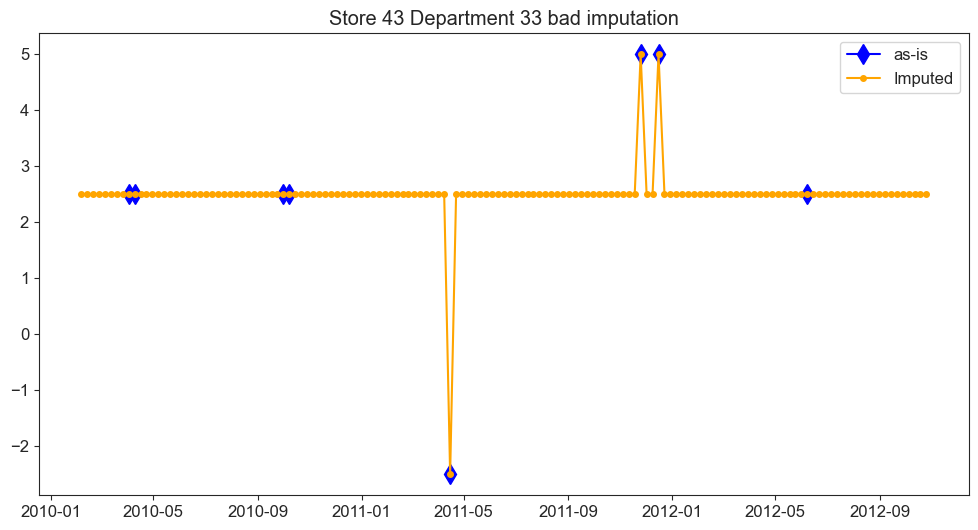

In [34]:
temp_copy = temp.copy()
# fill missing values in the time series
imputed_indices = temp[temp['Weekly_Sales'].isna()].index
df_median = df.groupby(["Store","New_Dept"],observed=False)["Weekly_Sales"].median().reset_index()
df_median.columns = ["Store","New_Dept","Weekly_Sales_to_fill"]
a = df.merge(df_median, on=["Store","New_Dept"])
a.loc[df.Weekly_Sales.isna(),"Weekly_Sales"] = a.loc[df.Weekly_Sales.isna(),"Weekly_Sales_to_fill"]
temp_imp = a.loc[(df.Store==43)&(df.New_Dept==33), ['Date','Weekly_Sales']]
# plot the original and imputed time series
plt.plot(temp['Date'], temp_copy['Weekly_Sales'], marker='d', label='as-is', color='blue', markersize=10)
plt.plot(temp_imp['Date'], temp_imp['Weekly_Sales'], marker='o', label='Imputed', color='orange', markersize=4)
plt.legend()
plt.title('Store 43 Department 33 bad imputation')
plt.show()

### 2.4.2 Missing imputations on store-department pairs with less than 20% missing values nor big gaps

Example showcase of the missing values imputation with zero and with STL can both provide satisfying results when the missing rate is high when working on a store-department scale. To demonstrate the imputation method, we will use the store-20-department-48 pair, who has 13 missing out of 143 weeks.

In [35]:
temp = df.loc[(df.Store==6)&(df.New_Dept==48), ['Date','Weekly_Sales']]
temp_copy = temp.copy(deep=True)
temp.isna().sum()

Date            0
Weekly_Sales    2
dtype: int64

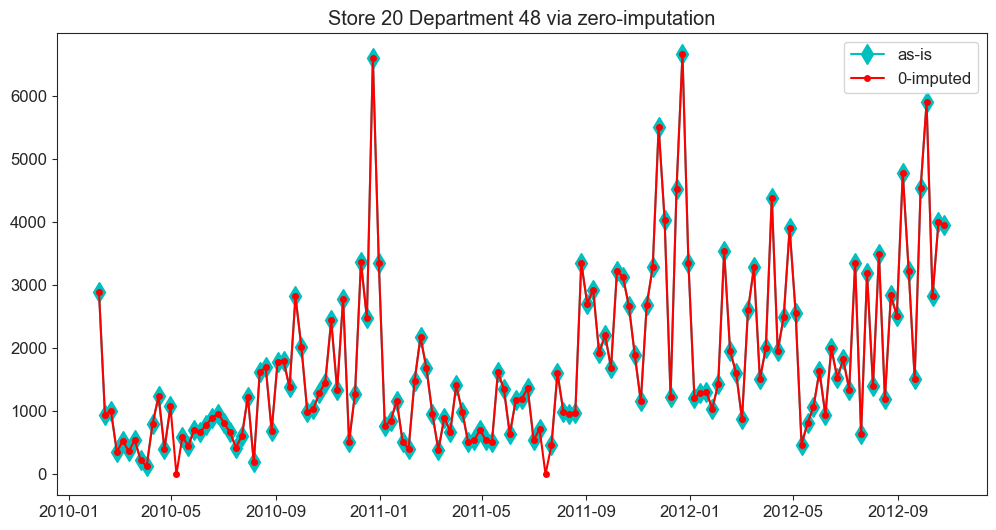

In [36]:
# zero-imputation
# fill the missing valus in temp with 0
temp_0 = temp.copy()
temp_0['Weekly_Sales'] = temp['Weekly_Sales'].fillna(0)
# plot the original and imputed time series
plt.plot(temp['Date'], temp_copy['Weekly_Sales'], marker='d', label='as-is', color='c', markersize=10)
plt.plot(temp['Date'], temp_0['Weekly_Sales'], marker='o', label='0-imputed', color='red', markersize=4)
plt.title('Store 20 Department 48 via zero-imputation')
plt.legend()
plt.show()

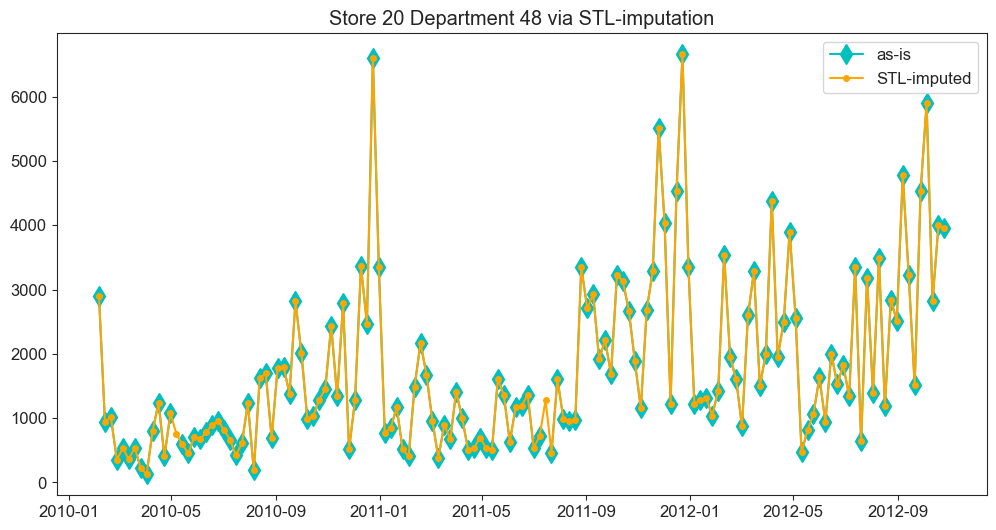

In [37]:
# STL-imputation
def stl_weeklysales(df, interpolate_method='linear', period=52):
	# find the imputed index
	imputed_indices = df[df['Weekly_Sales'].isna()].index
	# apply STL decomposition to the time series
	stl = STL(df['Weekly_Sales'].interpolate(method=interpolate_method), period=period)
	res = stl.fit()
	# extract the seasonal and trend components
	seasonal, trend = res.seasonal, res.trend
	# create the de-seasonalized and de-trended time series
	residual = df['Weekly_Sales'] - trend - seasonal
	# interpolate the missing values in the residual series
	residual_imp = residual.interpolate(method=interpolate_method)
	# add the seasonal and trend components back to the imputed residual series
	df_imp = residual_imp + trend + seasonal
	# make sure the imputed time series is non-negative
	df_imp[df_imp < 0] = 0
	# update the original time series with the imputed values
	df.loc[imputed_indices, 'Weekly_Sales'] = df_imp[imputed_indices]
	return df
# apply STL decomposition to the time series
temp_imp = stl_weeklysales(temp)
# plot the original and imputed time series
plt.plot(temp['Date'], temp_copy['Weekly_Sales'], marker='d', label='as-is', color='c', markersize=10)
plt.plot(temp['Date'], temp_imp['Weekly_Sales'], marker='o', label='STL-imputed', color='orange', markersize=4)
plt.title('Store 20 Department 48 via STL-imputation')
plt.legend()
plt.show()

Prepare the missing value imputation for the store-20(A)-department-48, store-13(A)-department-48 and store-6(A)-department-48 via both zero-imputation and STL-imputation. 

In [38]:
# prepare the zero-imputation and stl-imputation for store-20(A)-department-48
df_s20d48 = df.loc[(df.Store==20)&(df.New_Dept==48)]
df_s20d48_0 = df_s20d48.copy(deep=True)
# zero-impute df_s20d48
df_s20d48_0['Weekly_Sales'] = df_s20d48_0['Weekly_Sales'].fillna(0)
# STL-impute df_s20d48
df_s20d48_stl = stl_weeklysales(df_s20d48)
# prepare the zero-imputation and stl-imputation for store-13(A)-department-48
df_s13d48 = df.loc[(df.Store==13)&(df.New_Dept==48)]
df_s13d48_0 = df_s13d48.copy(deep=True)
# zero-impute df_s13d48
df_s13d48_0['Weekly_Sales'] = df_s13d48_0['Weekly_Sales'].fillna(0)
# STL-impute df_s13d48
df_s13d48_stl = stl_weeklysales(df_s13d48)
# prepare the zero-imputation and stl-imputation for store-6(A)-department-48
df_s6d48 = df.loc[(df.Store==6)&(df.New_Dept==48)]
df_s6d48_0 = df_s6d48.copy(deep=True)
# zero-impute df_s6d48
df_s6d48_0['Weekly_Sales'] = df_s6d48_0['Weekly_Sales'].fillna(0)
# STL-impute df_s6d48
df_s6d48_stl = stl_weeklysales(df_s6d48)

Prepare the missing value free dataframes of the store-20(A)-department-4, store-13(A)-department-4 and store-6(A)-department-4. 

In [39]:
# Prepare the df for store-20(A)-department-4, store-13(A)-department-4 and store-6(A)-department-4
df_s20d4 = df.loc[(df.Store==20)&(df.New_Dept==4)].copy(deep=True)
df_s13d4 = df.loc[(df.Store==13)&(df.New_Dept==4)].copy(deep=True)
df_s6d4 = df.loc[(df.Store==6)&(df.New_Dept==4)].copy(deep=True)
df_s20d4.isna().sum().sum()
df_s13d4.isna().sum().sum()
df_s6d4.isna().sum().sum()

0

## 2.5 Outlier detection and imputation

- Outliers should be screened per store-department pair,for the sales pattern and trend of the same store-department pair can be quite different from the sales pattern and trend of the same department in different stores or the same subcategory in different stores.
- Given the fact that holiday weeks are highly prioritised and tend to behave totally differently than the non-holiday weeks, we will perform outlier detection on non-holiday weeks ONLY and keep all the holiday weeks even though they normally appear to be outstanding visually.
- Similarly, we notice that many store markdowns (sale promotions) actually took place 2 weeks in prior to the holiday weeks and their weekly sales are compared to the holiday weeks. Therefore, we will also exclude the 2 non-holiday weeks before the holiday week as-is, meaning that __we will perform outlier detection on the non-holiday weeks that are not the 2 weeks before the holiday weeks__.
- Since we use rolling mean of the at least past 3 weeks of the non-holiday weeks, __the first 3 weeks cannot be regarded as outliers__.
- Use the Tukey's fences method will be used to detect the outliers. 
- We use Store 6 Department 4 (Papers) as an example to demonstrate the outlier detection and imputation.
- Conclusion: We further apply the outlier detection and imputation on the rest store-department pairs: Store-13-Department-4, Store-20-Department-4, Store-6-Department-48(zero and STL imputed), Store-13-Department-48(zero and STL imputed), Store-20-Department-48(zero and STL imputed). 

In [40]:
# define the Tukey's fence method to detect the outliers 
def tukey_fences(x, k=1.5):
	q1 = x.quantile(0.25)
	q3 = x.quantile(0.75)
	iqr = q3 - q1
	return (x < (q1 - k * iqr)) | (x > (q3 + k * iqr))
# define the function to get the outliers of a given store-dpet pair's weekly sales
def ws_getoutliers(x, k=1.5, leading_3_wks='2010-02-26'):
	# get the holiday dates plus 1 week before the holiday dates
	holiday_dates = x.loc[x.IsHoliday==True, 'Date']
	wk1_b4, wk2_b4 = holiday_dates - pd.DateOffset(weeks=1), holiday_dates - pd.DateOffset(weeks=2)
	twowks_b4_holiday_dates = pd.concat([wk1_b4, wk2_b4]).reset_index(drop=True).sort_values()
	# get the non-holiday weeks that are not the 2 week before the holiday weeks
	df_nh_n2b4 = x.loc[(x.IsHoliday==False)&(~x.Date.isin(twowks_b4_holiday_dates)),['Date','Weekly_Sales']]
	# use Tukey's fences method to get the outliers
	a = tukey_fences(df_nh_n2b4['Weekly_Sales'], k=k)
	# also we cannot label the first 3 weeks as outliers as we use the rolling mean of the past 3 weeks
	a[:3] = [False, False, False]
	outer_index = a[a].index
	return outer_index

In [41]:
 # define the function to impute the outliers of a given store-dept pair's weekly sales with the rolling mean of the past 3 weeks of the non-holiday weeks
def ws_imputeoutliers(x, outerIndex, rolling_window=3):
	# set the weekly_sales of the outliers in the df to np.nan
	x.loc[:,'Weekly_Sales_cp'] = x.loc[:,'Weekly_Sales'].values
	x.loc[outerIndex, 'Weekly_Sales_cp'] = np.nan
	# Use rolling mean of past 3 weeks to impute the outliers in 'Weekly_Sales' column and assign it to the 'Weekly_Sales_outerFill' column
	r_mean = x['Weekly_Sales_cp'].rolling(window=3, min_periods=1).mean()
	x.loc[:,'Weekly_Sales_outerFill'] = x.loc[:,'Weekly_Sales_cp'].fillna(r_mean)
	x.drop(columns='Weekly_Sales_cp', inplace=True)
	return x


### 2.5.1 Example: Outlier detection on df_s6d4 dataframes

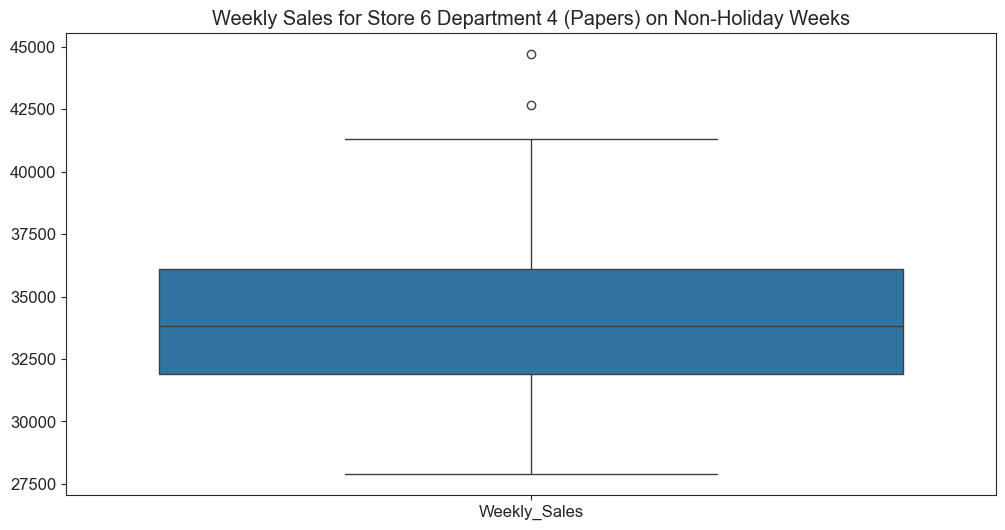

In [42]:
# find the index of the outliers in the df_s6d4, using Tukey's fences method with k = 1.5, also since we use rolling mean of the past 3 weeks of the non-holiday weeks, the first 3 weeks cannot be regarded as outliers. Furthermore, we will exclude the week before the holiday week as outliers.
temp = df_s6d4.copy()
outer_index = ws_getoutliers(temp)
outliers = temp.loc[outer_index, ['Date','Weekly_Sales']]
nh_temp = temp.loc[temp.IsHoliday==False, ['Date','Weekly_Sales']]
# use sns to plot the boxplot
sns.boxplot(nh_temp)
plt.title('Weekly Sales for Store 6 Department 4 (Papers) on Non-Holiday Weeks')
plt.show()

 Now, impute the outliers in the df_s6d4 dataframe with the rolling mean of the past 3 non-holiday weekly sales of the same store-department pair in the same week of the year.

In [43]:
temp.loc[outer_index]

,Store,Type,Size,New_Dept,Department Name,In Full Category,Merch Align,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Weekly_Sales,Year,Week
53524,6,A,202505,4,Paper Goods Household Paper,Consumables,Consumables,2012-07-06,82.95,3.227,6087.24,254.9,205.95,3655.34,5715.69,223.491985,5.668,False,44707.66,2012,27


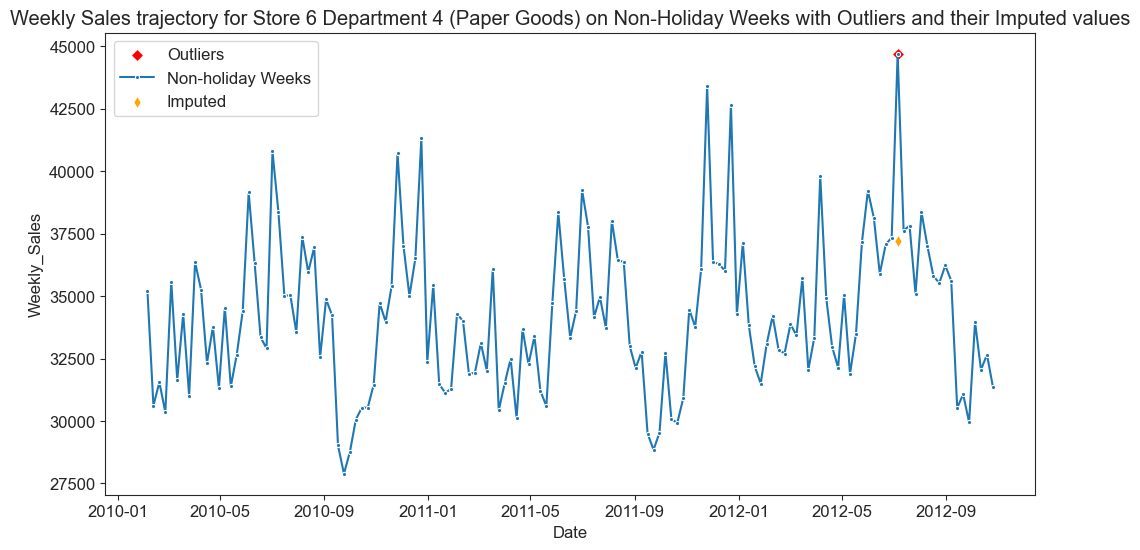

In [44]:
# impute the above outliers
if len(outer_index) > 0:
	temp = ws_imputeoutliers(temp, outer_index)
	# lineplot the original and imputed time series
	sns.scatterplot(x='Date', y='Weekly_Sales', data=outliers, marker='D', label='Outliers', color='r', sizes=10)
	sns.lineplot(x='Date', y='Weekly_Sales', data=temp, marker='.', label='Non-holiday Weeks')
	# scatter plot temp1 with the imputed values
	sns.scatterplot(x='Date', y='Weekly_Sales_outerFill', data=temp.loc[outer_index], marker='d', label='Imputed', c='orange', sizes=10)
	plt.title('Weekly Sales trajectory for Store 6 Department 4 (Paper Goods) on Non-Holiday Weeks with Outliers and their Imputed values')
	plt.show()
else:
	print(f'No outliers detected.')

# update the original df_s6d4 with the imputed values
df_s6d4.loc[outer_index, 'Weekly_Sales'] = temp.loc[outer_index, 'Weekly_Sales_outerFill'].values

### 2.5.2 Outlier detection and imputation on the rest dataframes, df_s13d4, df_s20d4, df_s6d48_0, df_s6d48_stl, df_s13d48_0, df_s13d48_stl, df_s20d48_0, df_s20d48_stl

In [45]:
window, i = 3, 0
for pair in [df_s13d4, df_s20d4, df_s6d48_0, df_s6d48_stl, df_s13d48_0, df_s13d48_stl, df_s20d48_0, df_s20d48_stl]:
	outer_index = ws_getoutliers(pair)
	if len(outer_index) > 0:
		pair = ws_imputeoutliers(pair, outer_index)
		# monitor if the fill column is na-free
		cond = pair['Weekly_Sales_outerFill'].isna().sum() == 0
		while not cond:
			window += 1
			pair['Weekly_Sales_outerFill'] = pair['Weekly_Sales'].fillna(pair['Weekly_Sales'].rolling(window, min_periods=1).mean())
			cond = pair['Weekly_Sales_outerFill'].isna().sum() == 0
		print(f'{len(outer_index)} outliers detected for the {i}-th dataframe and imputed.')	
		# update the original pair with the imputed values
		pair.loc[outer_index, 'Weekly_Sales'] = pair.loc[outer_index, 'Weekly_Sales_outerFill'].values
		# drop the 'Weekly_Sales_outerFill' column
		pair.drop(columns='Weekly_Sales_outerFill', inplace=True)
	else:
		print(f'No outliers detected for the {i}-th dataframe.')
	i += 1

1 outliers detected for the 0-th dataframe and imputed.
1 outliers detected for the 1-th dataframe and imputed.
7 outliers detected for the 2-th dataframe and imputed.
7 outliers detected for the 3-th dataframe and imputed.
No outliers detected for the 4-th dataframe.
No outliers detected for the 5-th dataframe.
6 outliers detected for the 6-th dataframe and imputed.
6 outliers detected for the 7-th dataframe and imputed.


# 3 Feature Engineering

## 3.1 Markdowns

As aforementioned, markdowns happen sporadically throughout the year round and highly holiday-dependent, we imputed their missing values with 0. In addition, the occurrence of markdowns is based on the policy of each store. Hence, we will sum up the markdowns 1-5 to create a new column 'MarkDown_tot' in all dataframes.

In [46]:
pairs = [df_s6d4, df_s13d4, df_s20d4, df_s6d48_0, df_s6d48_stl, df_s13d48_0, df_s13d48_stl, df_s20d48_0, df_s20d48_stl]
for pair in pairs:
	pair['MarkDown_tot'] = pair['MarkDown1'] + pair['MarkDown2'] + pair['MarkDown3'] + pair['MarkDown4'] + pair['MarkDown5']
	pair.drop(columns=['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace=True)

## 3.2 Convert isHoliday to isSB, isLD, isTG and isXM respectively
From our EDA, we know that the weekly sales of the store-department pairs are highly holiday-dependent, but not all holidays have equal effects. Therefore, to emphasize this disparity,  we will convert the 'isHoliday' column to 4 separate columns, 'isSB', 'isLD', 'isTG', and 'isXM', where 'isSB' stands for 'is Super Bowl', 'isLD' stands for 'is Labor Day', 'isTG' stands for 'is Thanksgiving', and 'isXM' stands for 'is Christmas'. In addition, we will add week counts to TG and XM of that year for they are the peak season of sales, and drop the original 'Week' column, so that we convert a categorical feature with relatively high cardinality to a numeric one.

In [47]:
holiday_dates = pd.to_datetime(['2010-02-12', '2010-09-10', '2010-11-26', '2010-12-31', '2011-02-11', '2011-09-09', '2011-11-25', '2011-12-30', '2012-02-10', '2012-09-07', '2012-11-23', '2012-12-28'])
# convert the 'isHoliday' column to 4 separate columns, 'isSB', 'isLD', 'isTG', and 'isXM'
for pair in pairs:
	pair['isSB'] = pair['Date'].isin(holiday_dates[0::4]).astype(int)
	pair['isLD'] = pair['Date'].isin(holiday_dates[1::4]).astype(int)
	pair['isTG'] = pair['Date'].isin(holiday_dates[2::4]).astype(int)
	pair['isXM'] = pair['Date'].isin(holiday_dates[3::4]).astype(int)
	pair.drop(columns='IsHoliday', inplace=True)
	pair.reset_index(drop=True, inplace=True)
	# add countdowns in week to TG and XM of that year, from 2010 to 2012, TG is always in week 47 and XM is always in week 52
	for row in range(pair.shape[0]):
		if pair.loc[row, 'Week'] <= 47:
			pair.loc[row, 'Wks2TG'] = 47 - pair.loc[row, 'Week']
		else:
			pair.loc[row, 'Wks2TG'] = 47 + 52 - pair.loc[row, 'Week']
	pair['Wks2XM'] = 52 - pair['Week']
	# drop the original 'Week' column
	pair.drop(columns='Week', inplace=True)

## 3.3 Add the preceding 2 weeks' weekly sales respectively as feature lag_1, lag_2
Since the weekly sales are innately autocorrelative, we will add the preceding 3 weeks' weekly sales as features 'lag_1', 'lag_2', 'lag_3' respectively. 

In [48]:
for pair in pairs:
	pair['lag_1'] = pair['Weekly_Sales'].shift(1)
	pair['lag_2'] = pair['Weekly_Sales'].shift(2)
	# drop the first 2 weeks because they have na in lag_1 and lag_2 by design
	pair.dropna(inplace=True)

## 3.4 Encode the categorical features

- Since we are performing analysis based on a store-department level, we can safely discard the following columns for their cardinalities being 1: ['Store', Type', 'Size', 'New_Dept', 'Department Name', 'In Full Category', 'Merch Align'.
- We will encode the 'Year'column with one-hot encoding because its cardinality is below 10.

In [49]:
pair = pairs[0].copy(deep=True)

In [50]:
pair.set_index('Date', inplace=True)

In [51]:
pair.drop(columns=['Store', 'Type', 'Size', 'New_Dept', 'Department Name', 'In Full Category', 'Merch Align'], inplace=True)

In [52]:
	# encode the 'Year' column with one-hot encoding
	encoder = preprocessing.OneHotEncoder(sparse_output=False, drop='first')
	pair['Year'] = pair['Year'].astype('category')
	encoded = encoder.fit_transform(pair[['Year']])
	encoded_df = pd.DataFrame(encoded, index=pair.index, columns=[f'Year+{i}' for i in range(1, len(encoder.categories_[0]))])
	pair.drop(columns=['Year'], inplace=True)

In [53]:
pair = pd.concat([pair, encoded_df], axis=1)

In [54]:
pair.head(1)

,Temperature,Fuel_Price,CPI,Unemployment,Weekly_Sales,MarkDown_tot,isSB,isLD,isTG,isXM,Wks2TG,Wks2XM,lag_1,lag_2,Year+1,Year+2
Date,,,,,,,,,,,,,,,,
2010-02-19,43.58,2.514,212.816155,7.259,31553.54,0.0,0,0,0,0,40.0,45,30612.26,35192.87,0.0,0.0


In [55]:
for _ in range(len(pairs)):
	pair = pairs[_].copy()
	# reset the index to the 'Date' column
	pair['Date'] =  pair['Date'].dt.date
	pair.set_index('Date', inplace=True)
	# drop the columns with cardinality 1
	pair.drop(columns=['Store', 'Type', 'Size', 'New_Dept', 'Department Name', 'In Full Category', 'Merch Align'], inplace=True)
	# encode the 'Year' column with one-hot encoding
	encoder = preprocessing.OneHotEncoder(sparse_output=False, drop='first')
	pair['Year'] = pair['Year'].astype('category')
	encoded = encoder.fit_transform(pair[['Year']])
	encoded_df = pd.DataFrame(encoded, index=pair.index, columns=[f'Year+{i}' for i in range(1, len(encoder.categories_[0]))])
	pair.drop(columns=['Year'], inplace=True)
	pairs[_] = pd.concat([pair, encoded_df], axis=1)

## 3.5 Normalize the numeric features

We aply the MinMaxScalar on feature columns ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown_tot', 'lag_1', 'lag_2','Wks2TG', 'Wks2XM'].

In [56]:
Scaler = preprocessing.MinMaxScaler()
for _ in range(len(pairs)):
	pairs[_][['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown_tot', 'lag_1', 'lag_2','Wks2TG', 'Wks2XM']] = Scaler.fit_transform(pairs[_][['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown_tot', 'lag_1', 'lag_2','Wks2TG', 'Wks2XM']])
	pairs[_] = pairs[_][['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown_tot', 'lag_1', 'lag_2','Wks2TG', 'Wks2XM', 'isSB', 'isLD', 'isTG', 'isXM', 'Year+1', 'Year+2']]

## 3.6 Train-Validation split

In [57]:
features = [feature for feature in pairs[0].columns if feature != 'Weekly_Sales']
x_trn, x_val, y_trn, y_val = [], [], [], []
print(f'The start date is {min(pairs[0].index)} and the end date is {max(pairs[0].index)}. There are {pairs[0].shape[0]} weeks. And we will use the first 136 weeks as training and the rest 5 weeks as validation.')
print(f'The time span of the training set is from {pairs[0].index[0]} to {pairs[0].index[135]}.')
print(f'The time span of the validation set is from {pairs[0].index[-5]} to {pairs[0].index[-1]}.')
print(f'There are {len(features)} normalized features in the dataframes. They are {features}.')

The start date is 2010-02-19 and the end date is 2012-10-26. There are 141 weeks. And we will use the first 136 weeks as training and the rest 5 weeks as validation.
The time span of the training set is from 2010-02-19 to 2012-09-21.
The time span of the validation set is from 2012-09-28 to 2012-10-26.
There are 15 normalized features in the dataframes. They are ['Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'MarkDown_tot', 'lag_1', 'lag_2', 'Wks2TG', 'Wks2XM', 'isSB', 'isLD', 'isTG', 'isXM', 'Year+1', 'Year+2'].


In [58]:
for pair in pairs:
	x_trn.append(pair.iloc[:136][features])
	x_val.append(pair.iloc[136:][features])
	y_trn.append(pair.iloc[:136]['Weekly_Sales'])
	y_val.append(pair.iloc[136:]['Weekly_Sales'])

In [59]:
x_trn[0].head(1)

,Temperature,Fuel_Price,CPI,Unemployment,MarkDown_tot,lag_1,lag_2,Wks2TG,Wks2XM,isSB,isLD,isTG,isXM,Year+1,Year+2
Date,,,,,,,,,,,,,,,
2010-02-19,0.098135,0.0,0.073639,1.0,0.0,0.175296,0.470219,0.784314,0.882353,0,0,0,0,0.0,0.0


In [87]:
# save x_trn, x_val, y_trn, y_val to disk
with open('x_trn.pkl', 'wb') as f:
	pickle.dump(x_trn, f)
with open('x_val.pkl', 'wb') as f:
	pickle.dump(x_val, f)
with open('y_trn.pkl', 'wb') as f:
	pickle.dump(y_trn, f)
with open('y_val.pkl', 'wb') as f:
	pickle.dump(y_val, f)

In [ ]:
# load x_trn, x_val, y_trn, y_val from disk
with open('x_trn.pkl', 'rb') as f:
	x_trn = pickle.load(f)
with open('x_val.pkl', 'rb') as f:
	x_val = pickle.load(f)
with open('y_trn.pkl', 'rb') as f:
	y_trn = pickle.load(f)
with open('y_val.pkl', 'rb') as f:
	y_val = pickle.load(f)

# 4. Modeling

We will attempt to make prediction on the 5-week interval of the validation set via 4 models: SARIMA, RandomForest, XGBoost, LightGBM, apply the SARIMA model on the store-20(A)-department-4, store-13(A)-department-4 and store-6(A)-department-4 pairs respectively.

In [82]:
# Eval metric for the competition
def WMAE(dt, real, predicted):
    weights = (dt['isSB']|dt['isLD']|dt['isTG']|dt['isXM']).apply(lambda x:5 if x else 1)
    return np.round(np.sum(weights*abs(real-predicted))/(np.sum(weights)), 2)

## 4.1 SARIMA
### 4.1.1 SARMIA on df_s6d4 (store-department) 

In [ ]:
x_train, y_train = x_trn[0], y_trn[0]
x_valid, y_valid = x_val[0], y_val[0]

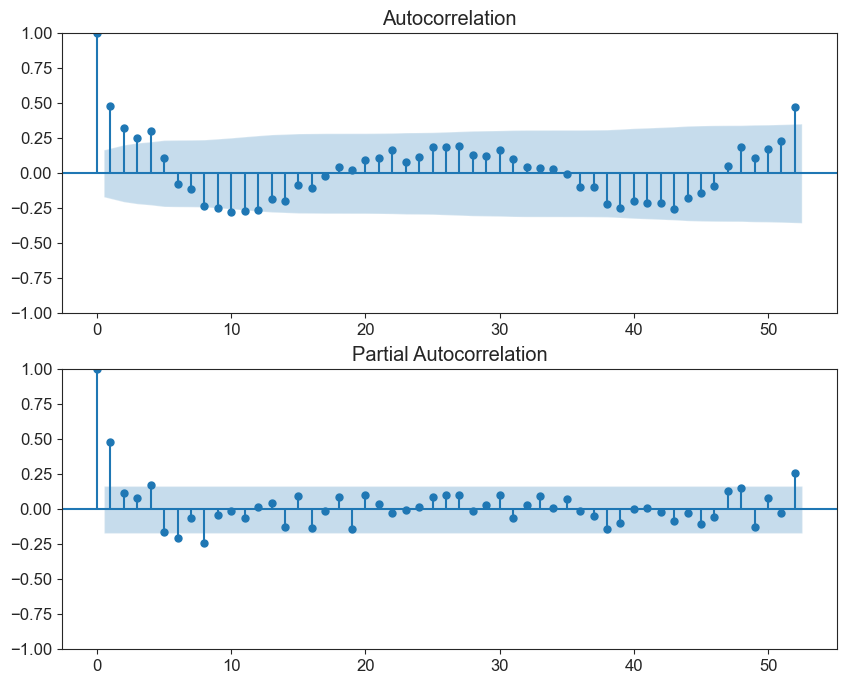

In [61]:
# show the ACF and PACF plots of the weekly sales
fig, ax = plt.subplots(2,1,figsize=(10,8))
plot_acf(y_train, lags=52, ax=ax[0])
plot_pacf(y_train, lags=52, ax=ax[1])
plt.show()

ACF suggests q won't exceed 4, and PACF suggests p won't exceed 3.

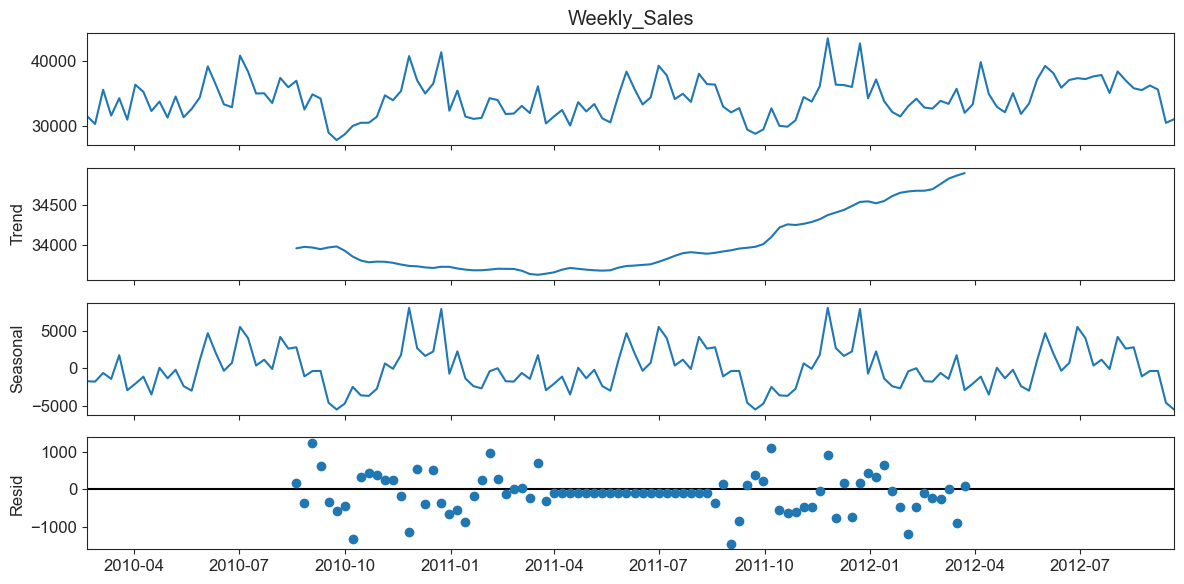

In [62]:
# show the seasonal decomposition 
decomp = seasonal_decompose(y_train,  period=52)
decomp.plot()
plt.show()

In [63]:
# find the hyperparameters best SARIMAX model
best_sarimax = pmd.auto_arima(y_train,exogenous=x_train.to_numpy(),
							 seasonal=True, m=52, 
							 d=None, D=None, 
							 start_p=0, start_q=0, 
							 max_p=2, max_q=2,
							 information_criterion='aic',test='adf', n_jobs=12,
							 error_action='ignore',stepwise=False, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=2534.461, Time=0.81 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2563.679, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2505.794, Time=1.05 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=inf, Time=2.27 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=3228.888, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[52] intercept   : AIC=2529.386, Time=0.04 sec
 ARIMA(1,0,0)(2,0,0)[52] intercept   : AIC=2504.213, Time=11.78 sec
 ARIMA(1,0,0)(2,0,1)[52] intercept   : AIC=inf, Time=38.72 sec
 ARIMA(1,0,0)(1,0,1)[52] intercept   : AIC=2496.864, Time=0.93 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=2498.032, Time=0.62 sec
 ARIMA(1,0,0)(1,0,2)[52] intercept   : AIC=inf, Time=32.09 sec
 ARIMA(1,0,0)(0,0,2)[52] intercept   : AIC=inf, Time=31.03 sec
 ARIMA(1,0,0)(2,0,2)[52] intercept   : AIC=inf, Time=42.48 sec
 ARIMA(2,0,0)(1,0,1)[52] intercept   : AIC=2495.922, Time=1.38 sec
 ARIMA(2,0,0)(0,0,1)[52] intercept   : 

In [64]:
# print out the arima result 
best_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  136
Model:             SARIMAX(2, 0, 1)x(1, 0, [], 52)   Log Likelihood               -1238.828
Date:                             Thu, 22 Aug 2024   AIC                           2489.657
Time:                                     00:45:23   BIC                           2507.133
Sample:                                 02-19-2010   HQIC                          2496.759
                                      - 09-21-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     1.4e+04   1.12e+04      1.252      0.210   -7910.978    3.59e+04
ar.L1         -0.3380      1.100     -0.307      0.759      -2.493       1.817
ar.L2          0.3764      0.463      0.812      0.417      -0.532       1.285
ma.L1          0.7581      1.150      0.659      0.510      -1.495       3.012
ar.S.L52       0.5761      0.105      5.466      0.000       0.370       0.783
sigma2       6.51e+06      4.765   1.37e+06      0.000    6.51e+06    6.51e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                14.00
Prob(Q):                              0.82   Prob(JB):                         0.00
Heteroskedasticity (H):               0.67   Skew:                             0.59
Prob(H) (two-sided):                  0.18   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.26e+23. Standard errors may be unstable.
"""

In [67]:
# define the model for SARIMAX
model = SARIMAX(y_train, order=(0,1,1), seasonal_order=(1,0,0,52),trend='c',
				exog=x_train.to_numpy(), enforce_stationarity=False, enforce_invertibility=False)

H:\Software\Anaconda3\envs\python-learn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
H:\Software\Anaconda3\envs\python-learn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [68]:
# fit the model
model_fit = model.fit(maxiter=200)

In [79]:
# making prediction using the model on validation
pred = model_fit.predict(start=136, end=140, exog=x_valid.to_numpy())

<Axes: title={'center': 'SARIMAX for store 6 department 4'}, xlabel='Date'>

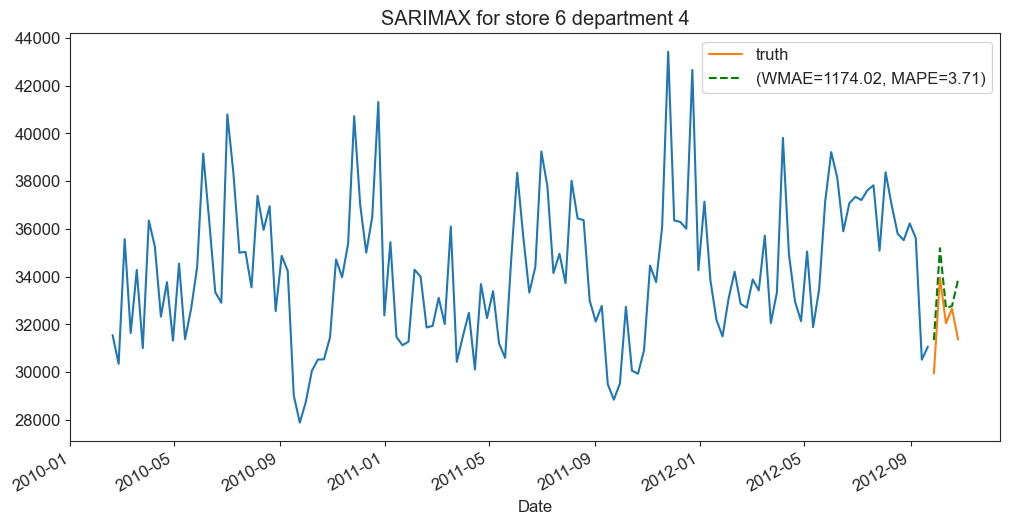

In [84]:
wmae = WMAE(x_valid, y_valid, pred)
mape = np.mean(np.abs((y_valid - pred) / y_valid)) * 100
y_train.plot()
y_valid.plot(legend=True, label='truth')  
pred.plot(linestyle='--', color='green', label="(WMAE={:0.2f}, MAPE={:0.2f})".format(wmae,mape), 
		  legend=True, title="SARIMAX for store 6 department 4")    

### 4.1.2 SARMIA on df_s13d4 (store-department) 


In [88]:
i=1
x_train, y_train = x_trn[i], y_trn[i]
x_valid, y_valid = x_val[i], y_val[i]

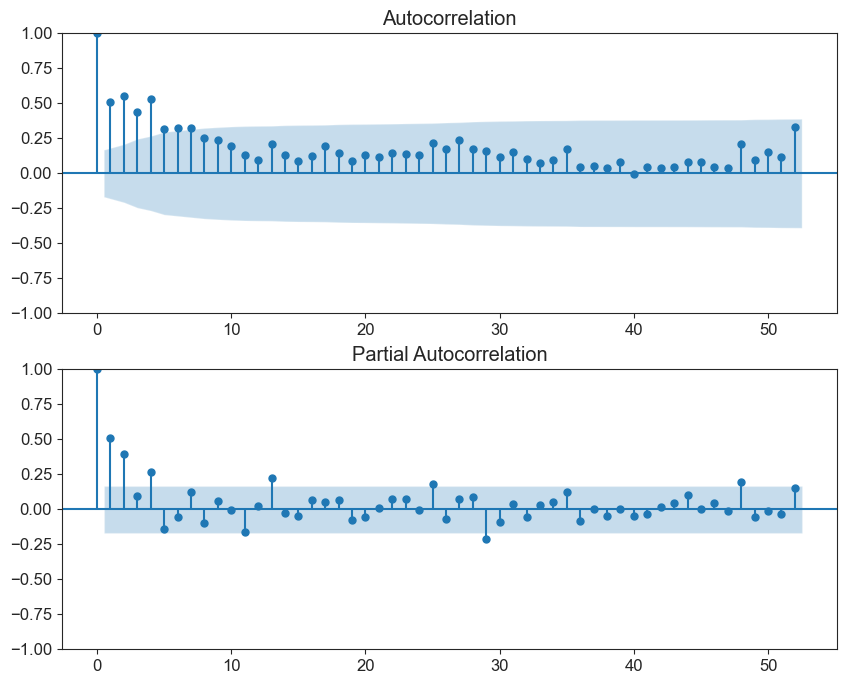

In [89]:
# show the ACF and PACF plots of the weekly sales
fig, ax = plt.subplots(2,1,figsize=(10,8))
plot_acf(y_train, lags=52, ax=ax[0])
plot_pacf(y_train, lags=52, ax=ax[1])
plt.show()

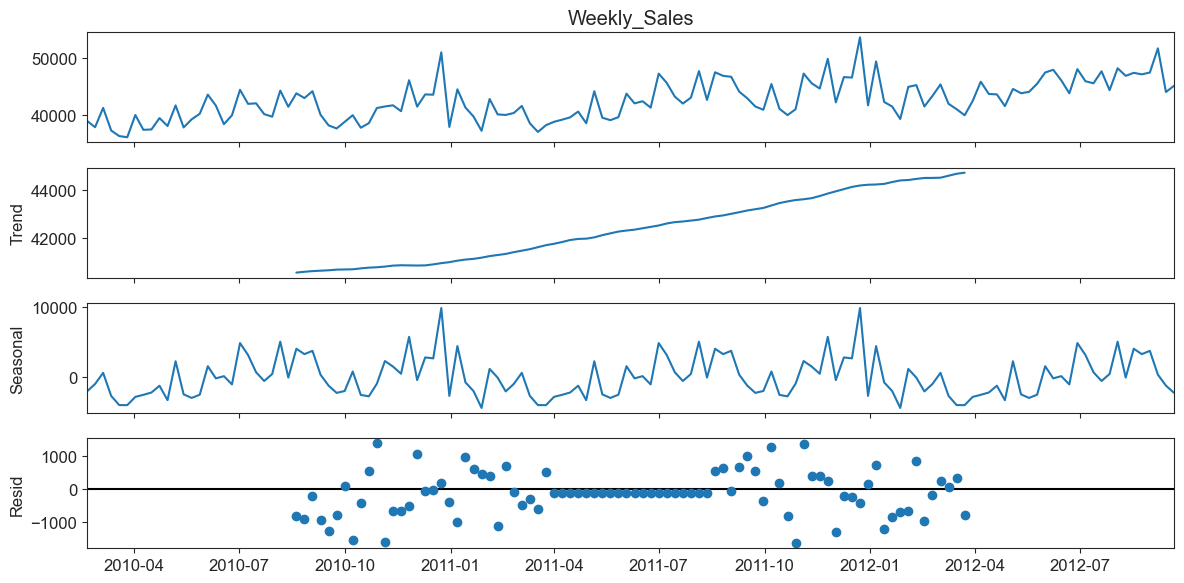

In [90]:
# show the seasonal decomposition 
decomp = seasonal_decompose(y_train,  period=52)
decomp.plot()
plt.show()

In [104]:
# find the hyperparameters best SARIMAX model
best_sarimax = pmd.auto_arima(y_train,exogenous=x_train.to_numpy(),
							 seasonal=True, m=52, 
							 d=None, D=None, 
							 start_p=0, start_q=0, 
							 max_p=2, max_q=2,
							 information_criterion='aic',test='adf', n_jobs=12,
							 error_action='ignore',stepwise=False, trace=True)


Best model:  ARIMA(1,0,1)(2,0,0)[52] intercept
Total fit time: 77.458 seconds


In [92]:
# print out the arima result 
best_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  136
Model:             SARIMAX(2, 0, 0)x(0, 0, [1, 2], 52)   Log Likelihood               -1252.106
Date:                                 Thu, 22 Aug 2024   AIC                           2516.211
Time:                                         01:22:39   BIC                           2533.687
Sample:                                     02-19-2010   HQIC                          2523.313
                                          - 09-21-2012                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.271e+04   6000.428      2.117      0.034     945.172    2.45e+04
ar.L1          0.3248      0.125      2.603      0.009       0.080       0.569
ar.L2          0.3770      0.163      2.320      0.020       0.059       0.696
ma.S.L52       0.5774      0.246      2.347      0.019       0.095       1.059
ma.S.L104      0.2493      0.477      0.523      0.601      -0.686       1.185
sigma2      7.438e+06      1.778   4.18e+06      0.000    7.44e+06    7.44e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.34   Jarque-Bera (JB):                 4.16
Prob(Q):                              0.56   Prob(JB):                         0.12
Heteroskedasticity (H):               1.04   Skew:                             0.36
Prob(H) (two-sided):                  0.89   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.91e+22. Standard errors may be unstable.
"""

In [105]:
# define the model for SARIMAX
model = SARIMAX(y_train, order=(1,0,1), seasonal_order=(2,0,0,52),trend='c',
				exog=x_train.to_numpy(), enforce_stationarity=False, enforce_invertibility=False)

H:\Software\Anaconda3\envs\python-learn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
H:\Software\Anaconda3\envs\python-learn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [106]:
# fit the model
model_fit = model.fit(maxiter=200)

In [107]:
# making prediction using the model on validation
pred = model_fit.predict(start=136, end=140, exog=x_valid.to_numpy())

<Axes: title={'center': 'SARIMAX for store 13 department 4'}, xlabel='Date'>

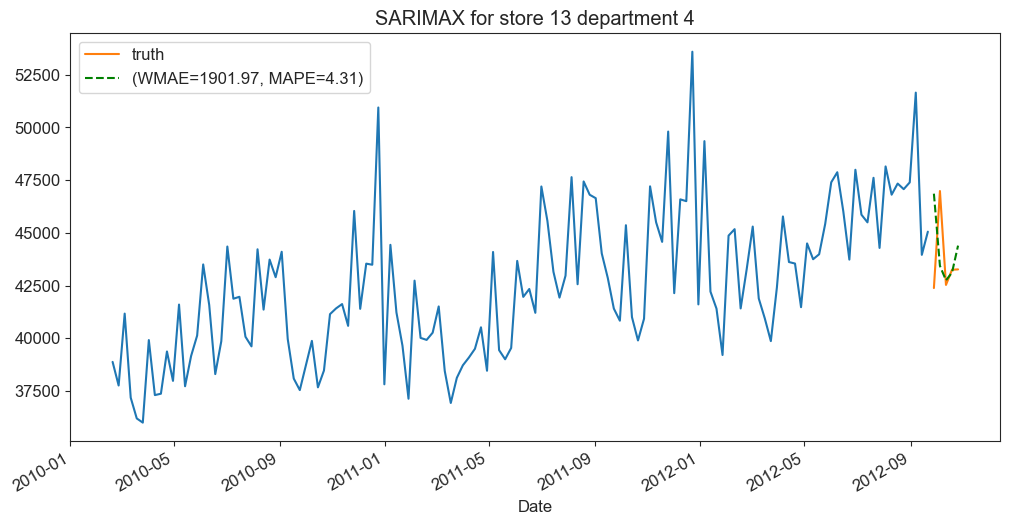

In [109]:
wmae = WMAE(x_valid, y_valid, pred)
mape = np.mean(np.abs((y_valid - pred) / y_valid)) * 100
y_train.plot()
y_valid.plot(legend=True, label='truth')  
pred.plot(linestyle='--', color='green', label="(WMAE={:0.2f}, MAPE={:0.2f})".format(wmae,mape), 
		  legend=True, title="SARIMAX for store 13 department 4")    

### 4.1.3 SARMIA on df_s20d4 (store-department)

In [110]:
i=2
x_train, y_train = x_trn[i], y_trn[i]
x_valid, y_valid = x_val[i], y_val[i]

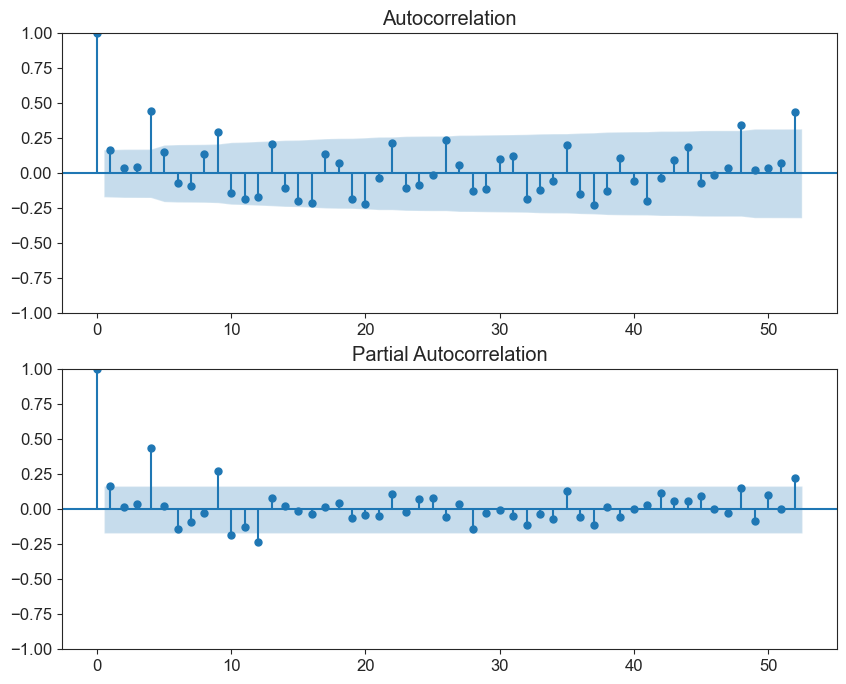

In [111]:
# show the ACF and PACF plots of the weekly sales
fig, ax = plt.subplots(2,1,figsize=(10,8))
plot_acf(y_train, lags=52, ax=ax[0])
plot_pacf(y_train, lags=52, ax=ax[1])
plt.show()

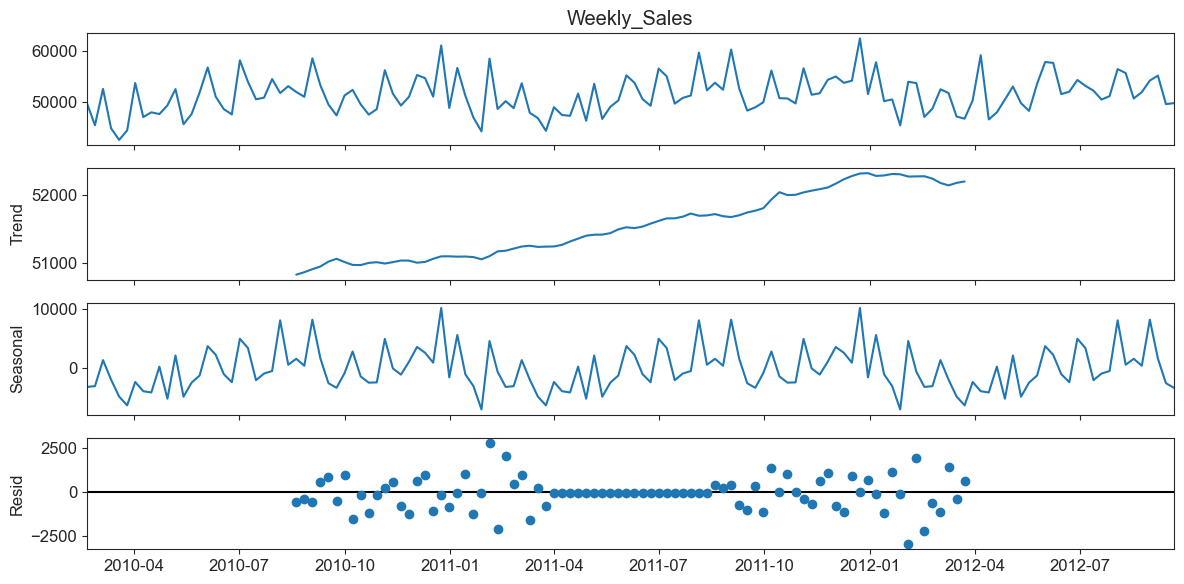

In [112]:
# show the seasonal decomposition 
decomp = seasonal_decompose(y_train,  period=52)
decomp.plot()
plt.show()

In [113]:
# find the hyperparameters best SARIMAX model
best_sarimax = pmd.auto_arima(y_train,exogenous=x_train.to_numpy(),
							 seasonal=True, m=52, 
							 d=None, D=None, 
							 start_p=0, start_q=0, 
							 max_p=2, max_q=2,
							 information_criterion='aic',test='adf', n_jobs=12,
							 error_action='ignore',stepwise=False, trace=True)


Best model:  ARIMA(1,0,2)(1,0,0)[52] intercept
Total fit time: 91.097 seconds


In [114]:
# print out the arima result 
best_sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  136
Model:             SARIMAX(1, 0, 2)x(1, 0, [], 52)   Log Likelihood               -1291.784
Date:                             Thu, 22 Aug 2024   AIC                           2595.568
Time:                                     01:36:34   BIC                           2613.043
Sample:                                 02-19-2010   HQIC                          2602.669
                                      - 09-21-2012                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.756e+04   1.28e+04      2.930      0.003    1.24e+04    6.27e+04
ar.L1         -0.7390      0.413     -1.787      0.074      -1.549       0.071
ma.L1          0.8491      0.414      2.050      0.040       0.037       1.661
ma.L2          0.1936      0.135      1.439      0.150      -0.070       0.457
ar.S.L52       0.5802      0.106      5.484      0.000       0.373       0.788
sigma2      1.304e+07      9.551   1.37e+06      0.000     1.3e+07     1.3e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):                 8.23
Prob(Q):                              0.70   Prob(JB):                         0.02
Heteroskedasticity (H):               0.78   Skew:                             0.46
Prob(H) (two-sided):                  0.40   Kurtosis:                         3.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.9e+21. Standard errors may be unstable.
"""

In [115]:
# define the model for SARIMAX
model = SARIMAX(y_train, order=(1,0,2), seasonal_order=(1,0,0,52),trend='c',
				exog=x_train.to_numpy(), enforce_stationarity=False, enforce_invertibility=False)

H:\Software\Anaconda3\envs\python-learn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
H:\Software\Anaconda3\envs\python-learn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)


In [119]:
# fit the model
model_fit = model.fit(maxiter=200)

In [107]:
# making prediction using the model on validation
pred = model_fit.predict(start=136, end=140, exog=x_valid.to_numpy())

<Axes: title={'center': 'SARIMAX for store 13 department 4'}, xlabel='Date'>

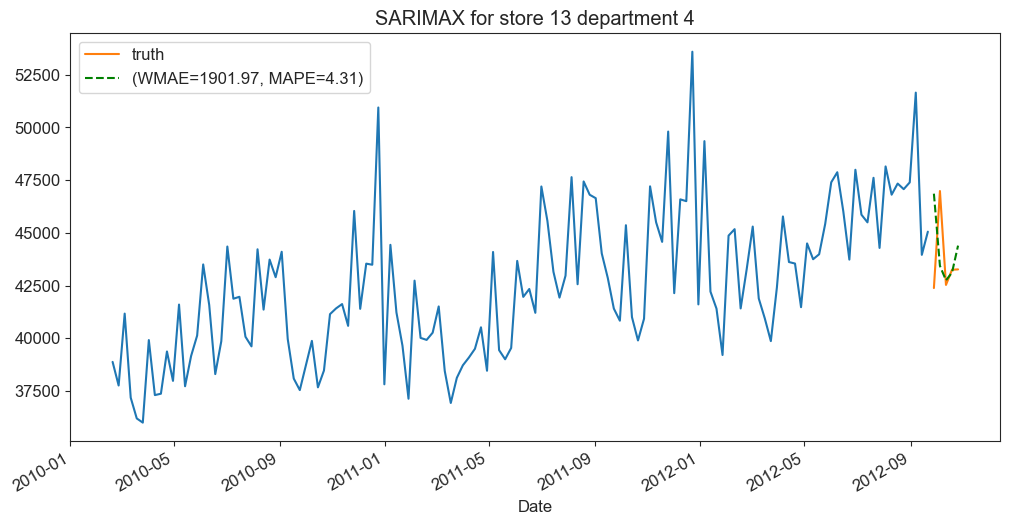

In [109]:
wmae = WMAE(x_valid, y_valid, pred)
mape = np.mean(np.abs((y_valid - pred) / y_valid)) * 100
y_train.plot()
y_valid.plot(legend=True, label='truth')  
pred.plot(linestyle='--', color='green', label="(WMAE={:0.2f}, MAPE={:0.2f})".format(wmae,mape), 
		  legend=True, title="SARIMAX for store 20 department 4")    

In [100]:
sdw.describe().T.style.bar(subset=['mean'], color='#205ff2')\
							.set_caption("Stats Summary of Numeric Variables")\
							.background_gradient(subset=['min'], cmap='Reds')\
							.background_gradient(subset=['max'], cmap='Greens')\
							.background_gradient(subset=['std'], cmap='GnBu')\
							.background_gradient(subset=['50%'], cmap='GnBu')

,count,mean,std,min,25%,50%,75%,max
Store,476333.000000,22.497448,12.831751,1.000000,11.000000,22.000000,33.000000,45.000000
Size,476333.000000,133950.658361,61889.885131,34875.000000,93188.000000,128107.000000,202505.000000,219622.000000
Dept,476333.000000,45.715101,30.141421,1.000000,20.000000,41.000000,74.000000,99.000000
Temperature,476333.000000,60.333886,18.452828,-2.060000,47.070000,62.360000,74.600000,100.140000
Fuel_Price,476333.000000,3.359182,0.458859,2.472000,2.932000,3.452000,3.737000,4.468000
MarkDown1,168943.000000,7090.052321,8238.921862,0.270000,2034.630000,5197.640000,9082.610000,88646.760000
MarkDown2,123431.000000,3278.825551,9366.852656,-265.760000,40.000000,190.980000,1891.530000,104519.540000
MarkDown3,152700.000000,1390.253102,9435.843266,-29.100000,4.930000,23.900000,101.860000,141630.610000
MarkDown4,149148.000000,3345.447838,6247.805509,0.220000,499.880000,1455.150000,3557.170000,67474.850000
MarkDown5,169881.000000,4542.875820,5905.099809,135.160000,1797.840000,3281.610000,5507.250000,108519.280000


In [ ]:
besides total markdown, add a boolean column to indicate whether markdown is available that week for this store. 

 Reconstruct the joined dataframe df based on the store-category/subcategory and aggregate the weekly sales
- We will first try to aggregate the df by the store-subcategory pairs. We might try to work in the store-category scale later.
- We will then sum up the weekly sales for each store-subcategory pair.
- We will then drop columns ['New_Dept','Department Name', 'In Full Category'] since we no longer use them.
- We will then left join the df_merc with the stores table to get the store type and size information.
- We will then right join the df_merc with the features table to get all the features at all weeks during the time period for each store-department pair.
- We will then drop weeks greater than the max date in train1 data, since we don't have sales data for those weeks.
- We will then convert the ['Store', 'Merch Align'] column to categorical types.
- We will then extract the year and week from the ['Date'] column to create new columns ['Year', 'Week'].
- We will then fill the missing values in the markdown1-5 columns with 0.
- At last, we end up with a NA-free dataframe df_merc, which is a 51,480 entries by 16 columns. 51,480 = 45 stores * 8 sub-categories * 143 weeks.

In [257]:
df['Merch Align'].value_counts(dropna=False)

Merch Align
Apparel                              92235
Food                                 83083
Hardlines                            59202
Entertainment, Toys, and Seasonal    51480
Home                                 44759
Consumables                          38610
Service                              21164
Health and Wellness                  12870
Name: count, dtype: int64

In [258]:
df['In Full Category'].value_counts(dropna=False)

In Full Category
General Merchandise    241241
Food                    83083
Consumables             45045
Service                 21164
Health and Wellness     12870
Name: count, dtype: int64

In [270]:
# Aggregate the df by the store-subcategory pairs
df_merc = df.loc[:, ].groupby(['Store','Merch Align','Date'], observed=True).agg({'Weekly_Sales':'sum'}).reset_index()
# left join df_merc with stores to get the store type and size information
df_merc = df_merc.merge(stores, on='Store', how='left')
# right join df_merc with features to get all the features at all weeks during the time period for each store-department pair
features['Date'] = pd.to_datetime(features['Date'])
df_merc = df_merc.merge(features, on = ["Store", 'Date'], how="right")
# drop weeks greater than max date in train1 data, since we don't have sales data for those weeks
df_merc = df_merc[df_merc["Date"]<=max_date].reset_index(drop=True)
# Convert the ['Store', 'Merch Align'] column to categorical types
df_merc['Store'] = df_merc['Store'].astype('category')
df_merc['Merch Align'] = df_merc['Merch Align'].astype('category')
# Extract the year and week from the ['Date'] column to create new columns ['Year', 'Week']
df_merc['Year'] = df_merc['Date'].dt.year
df_merc['Week'] = df_merc['Date'].dt.isocalendar().week
# fill the missing values in the markdown1-5 columns with 0
df_merc[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']] = df_merc[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']].fillna(0)


In [260]:
# No NAs in weekly sales due to the aggregation by sub-category
df_merc.isna().sum().sort_values(ascending=False).head()

Store           0
Merch Align     0
Year            0
IsHoliday       0
Unemployment    0
dtype: int64

###  Outlier detection on df_merc (store-subcategory) dataframes

In [275]:
# Outlier detection on non-holiday weekly_sales of df_merc by store-subcategory pairs by via for-loop
# define the windown length to do the rolling average imputation
window = 3
for store in df_merc['Store'].unique():
	for subcat in df_merc['Merch Align'].unique():
		ws = df_merc.loc[(df_merc.Store==store)&(df_merc['Merch Align']==subcat)&(df_merc.IsHoliday==False), ['Date','Weekly_Sales']]
		outer_index = tukey_fences(ws['Weekly_Sales']) & (ws['Date']>'2010-03-05') & (~ws['Date'].isin(twowks_b4_holiday_dates))
		outer = ws[outer_index]
		if len(outer) > 0:
			ws['Weekly_Sales_cp'] = ws['Weekly_Sales']
			ws.loc[outer_index, 'Weekly_Sales'] = np.nan
			ws['Weekly_Sales_outerFill'] = ws['Weekly_Sales'].fillna(ws['Weekly_Sales'].rolling(window, min_periods=1).mean())
			# monitor if the fill column is na-free
			cond = ws['Weekly_Sales_outerFill'].isna().sum() == 0
			while not cond:
				window += 1
				ws['Weekly_Sales_outerFill'] = ws['Weekly_Sales'].fillna(ws['Weekly_Sales'].rolling(window, min_periods=1).mean())
				cond = ws['Weekly_Sales_outerFill'].isna().sum() == 0
			df_merc.loc[(df_merc.Store==store)&(df_merc['Merch Align']==subcat)&(df_merc.IsHoliday==False), 'Weekly_Sales'] = ws['Weekly_Sales_outerFill']


Example: What if we don't not use elastic window for the rolling mean imputation?

In [271]:
store = 12
subcat = 'Home'
ws = df_merc.loc[(df_merc.Store==store)&(df_merc['Merch Align']==subcat)&(df_merc.IsHoliday==False), ['Date','Weekly_Sales']]
outer_index = tukey_fences(ws['Weekly_Sales']) & (ws['Date']>='2010-03-05') & (~ws['Date'].isin(twowks_b4_holiday_dates)) 
outer = ws[outer_index]

In [273]:
ws[outer_index]

,Date,Weekly_Sales
12622,2010-03-05,110978.92
13438,2012-02-17,124735.13
13446,2012-02-24,115913.93
13454,2012-03-02,120390.28
13462,2012-03-09,112535.77


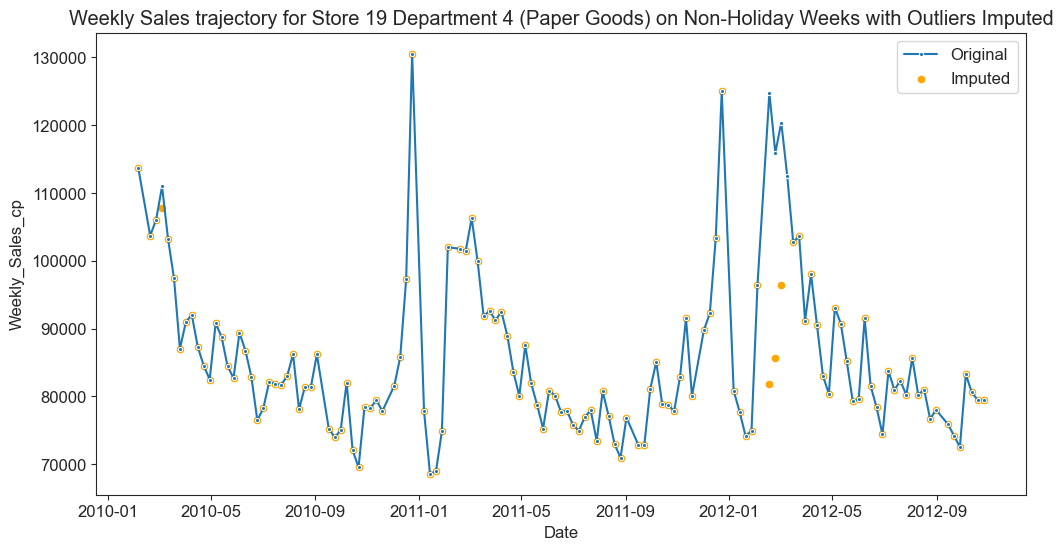

In [274]:
ws['Weekly_Sales_cp'] = ws['Weekly_Sales']
ws.loc[outer_index, 'Weekly_Sales'] = np.nan
ws['Weekly_Sales_outerFill'] = ws['Weekly_Sales'].fillna(ws['Weekly_Sales'].rolling(4, min_periods=1).mean())
# lineplot the original and imputed time series
sns.lineplot(x='Date', y='Weekly_Sales_cp', data=ws, marker='.', label='Original')
sns.scatterplot(x='Date', y='Weekly_Sales_outerFill', data=ws, marker='o', label='Imputed', c='orange')
plt.title('Weekly Sales trajectory for Store 19 Department 4 (Paper Goods) on Non-Holiday Weeks with Outliers Imputed')
plt.show()

In [276]:
df_merc[df_merc['Weekly_Sales'].isna()]

,Store,Merch Align,Date,Weekly_Sales,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Year,Week
